In [35]:
from benchmark_consts import get_problems, get_args_and_problems, print_, PATH_FORM_HYPERPARAMS


import os
import pickle
import traceback
import argparse
import random
import math

import sys
sys.path.append('..')

from lib.algorithms import PathFormulation
from lib.problem import Problem
from lib.algorithms.abstract_formulation import Objective
from lib.graph_utils import compute_in_or_out_flow, path_to_edge_list, assert_flow_conservation, check_feasibility
from collections import defaultdict
import ncflow

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
startTime = datetime.now()

TOP_DIR = 'path-form-logs'
HEADERS = [
    'problem', 'num_nodes', 'num_edges', 'traffic_seed', 'scale_factor',
    'tm_model', 'num_commodities', 'total_demand', 'algo', 'num_paths',
    'edge_disjoint', 'dist_metric', 'total_flow', 'runtime'
]
PLACEHOLDER = ','.join('{}' for _ in HEADERS)


In [12]:
# paths_dict: key: (source, target), value: array of paths,
#             where a path is a list of sequential nodes
#             use lib.graph_utils.path_to_edge_list to get edges.
def split_problem_smartpath(problem, num_subproblems, paths_dict):
    com_list = problem.commodity_list
    
    # create dictionary of all edges used by each commodity
    com_path_edges_dict = defaultdict(list)
    for k, (source, target, demand) in com_list:
        paths_array = paths_dict[(source, target)]
        for path in paths_array:
            com_path_edges_dict[(k, source, target)] += list(path_to_edge_list(path))
        
    # for each edge, split all commodities using that edge across subproblems
    subproblem_com_indices = defaultdict(list)
    current_subproblem = 0
    for (u,v) in problem.G.edges:
        coms_on_edge = [x for x in com_path_edges_dict.keys() if (u,v) in com_path_edges_dict[x]]
        
        # split commodities that share path across all subproblems
        for (k, source, target) in coms_on_edge:
            subproblem_com_indices[current_subproblem] += [(k,source,target)]
            current_subproblem = (current_subproblem + 1) % num_subproblems
            # remove commodity from cosideration when processing later edges
            del com_path_edges_dict[(k, source, target)]
    
    # create subproblems, zero out commodities in traffic matrix that aren't assigned to each 
    sub_problems = []
    for i in range(num_subproblems):
        
        sub_problems.append(problem.copy())
        
        #zero out all commodities not assigned to subproblem i
        for k in subproblem_com_indices.keys():
            if k == i:
                continue
            zero_out_list = subproblem_com_indices[k]
            for ind, source, target in zero_out_list:
                sub_problems[-1].traffic_matrix.tm[source,target] = 0
        
        # split the capacity of each link
        for u,v in sub_problems[-1].G.edges:
            sub_problems[-1].G[u][v]['capacity'] = sub_problems[-1].G[u][v]['capacity']/num_subproblems
    
    return sub_problems
        
#Input: a Problem, and a list of number representing the divisions
def split_problem(problem, num_subproblems):
    sub_problems = []
    num_rows = len(problem.traffic_matrix.tm)
    rows_per_problem = math.floor(num_rows/num_subproblems)
    shuffled_indices = list(range(num_rows))
    
    for i in range(num_subproblems):
        
        sub_problems.append(problem.copy())
        for indx, j in enumerate(shuffled_indices):
            
            # zero out all rows except those in the corresponding block of shuffled indices
            # first, cover special case for last block
            if i == num_subproblems-1:
                if indx < i*rows_per_problem:
                    sub_problems[-1].traffic_matrix.tm[j,:] = 0
            
            elif (indx < i*rows_per_problem) or (indx >= (i+1)*rows_per_problem):
                sub_problems[-1].traffic_matrix.tm[j,:] = 0
            
        # split the capacity of each link
        for u,v in sub_problems[-1].G.edges:
            sub_problems[-1].G[u][v]['capacity'] = sub_problems[-1].G[u][v]['capacity']/num_subproblems

    return sub_problems
        
# Sweep topos and traffic matrices for that topo. For each combo, record the
# runtime and total flow for each algorithm
def benchmark_split(problems, num_subproblems_list, obj, smart=True):
    num_paths, edge_disjoint, dist_metric = PATH_FORM_HYPERPARAMS
    
    if (obj == 'max_flow'):
        pf_original = PathFormulation.new_max_flow(
            num_paths,
            edge_disjoint=edge_disjoint,
            dist_metric=dist_metric)
    elif (obj == 'min_max_link_util'):
        pf_original = PathFormulation.new_min_max_link_util(
            num_paths,
            edge_disjoint=edge_disjoint,
            dist_metric=dist_metric)
    else:
        print(obj + " not supported")
        return
    
    all_results = {}
    all_runtimes = {}
    all_sol_dicts = {}
    with open('path-form.csv', 'a') as results:
        print_(','.join(HEADERS), file=results)
        for problem_name, topo_fname, tm_fname in problems:
            problem = Problem.from_file(topo_fname, tm_fname)
            
            paths_dict = pf_original.get_paths(problem)
            
            problem_results = [[] for _ in range(len(num_subproblems_list))]
            problem_runtimes = [[] for _ in range(len(num_subproblems_list))]
            problem_sol_dicts = [[] for _ in range(len(num_subproblems_list))]
            for nsp_i, num_subproblems in enumerate(num_subproblems_list):
                
                if smart:
                    problem_list = split_problem_smartpath(problem, num_subproblems, paths_dict)
                else:
                    problem_list = split_problem(problem, num_subproblems)
                sum_obj_val = 0
                for sp_i, sub_problem in enumerate(problem_list):

                    print_(sub_problem.name, tm_fname)
                    traffic_seed = sub_problem.traffic_matrix.seed
                    total_demand = sub_problem.total_demand
                    print_('traffic seed: {}'.format(traffic_seed))
                    print_('traffic scale factor: {}'.format(
                        sub_problem.traffic_matrix.scale_factor))
                    print_('traffic matrix model: {}'.format(
                        sub_problem.traffic_matrix.model))
                    print_('total demand: {}'.format(total_demand))

                    run_dir = os.path.join(
                        TOP_DIR, sub_problem.name,
                        '{}-{}'.format(traffic_seed, sub_problem.traffic_matrix.model))
                    if not os.path.exists(run_dir):
                        os.makedirs(run_dir)

                    try:
                        print_(
                            '\nPath formulation, {} paths, edge disjoint {}, dist metric {}'
                            .format(num_paths, edge_disjoint, dist_metric))
                        with open(
                                os.path.join(
                                    run_dir,
                                    '{}-path-formulation_{}-paths_edge-disjoint-{}_dist-metric-{}.txt'
                                    .format(sub_problem.name, num_paths, edge_disjoint,
                                            dist_metric)), 'w') as log:
                            
                            if (obj == 'max_flow'):
                                pf = PathFormulation.new_max_flow(
                                    num_paths,
                                    edge_disjoint=edge_disjoint,
                                    dist_metric=dist_metric,
                                    out=log)
                            elif (obj == 'min_max_link_util'):
                                pf = PathFormulation.new_min_max_link_util(
                                    num_paths,
                                    edge_disjoint=edge_disjoint,
                                    dist_metric=dist_metric,
                                    out=log)
                            else:
                                print(obj + " not supported")
                                break

                            pf.solve(sub_problem)
                            pf_sol_dict = pf.extract_sol_as_dict()
                            with open(
                                    os.path.join(
                                        run_dir,
                                        '{}-path-formulation_{}-paths_edge-disjoint-{}_dist-metric-{}_sol-dict.pkl'
                                        .format(sub_problem.name, num_paths, edge_disjoint,
                                                dist_metric)), 'wb') as w:
                                pickle.dump(pf_sol_dict, w)

                        result_line = PLACEHOLDER.format(
                            sub_problem.name,
                            len(sub_problem.G.nodes),
                            len(sub_problem.G.edges),
                            traffic_seed,
                            sub_problem.traffic_matrix.scale_factor,
                            sub_problem.traffic_matrix.model,
                            len(problem.commodity_list),
                            total_demand,
                            'path_formulation',
                            num_paths,
                            edge_disjoint,
                            dist_metric,
                            pf.obj_val,
                            pf.runtime,
                        )
                        print_(result_line, file=results)
                        problem_results[nsp_i].append(pf.obj_val)
                        problem_runtimes[nsp_i].append(pf.runtime)
                        problem_sol_dicts[nsp_i].append(pf_sol_dict)
                        sum_obj_val += pf.obj_val
                    except Exception:
                        print_(
                            'Path formulation {} paths, edge disjoint {}, dist metric {}, Problem {}, traffic seed {}, traffic model {} failed'
                            .format(num_paths, edge_disjoint, dist_metric,
                                    sub_problem.name, traffic_seed,
                                    sub_problem.traffic_matrix.model))
                        traceback.print_exc(file=sys.stdout)
                print("sum of obj vals: " + str(sum_obj_val))
               
            all_results[(problem_name, topo_fname, tm_fname)] = problem_results
            all_runtimes[(problem_name, topo_fname, tm_fname)] = problem_runtimes
            all_sol_dicts[(problem_name, topo_fname, tm_fname)] = problem_sol_dicts
    return all_results, all_runtimes, all_sol_dicts

In [30]:
parser = argparse.ArgumentParser()
parser.add_argument('--dry-run',
                        dest='dry_run',
                        action='store_true',
                        default=False)

parser.add_argument('--slices',
                        type=int,
                        choices=range(5),
                        nargs='+',
                        required=True)
args = parser.parse_args("--slices 0".split())

if not os.path.exists(TOP_DIR):
    os.makedirs(TOP_DIR)

#problems = get_problems(args)

if args.dry_run:
    print('Problems to run:')
    for problem in problems:
        print(problem)

p1 = ("uniform 64", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl")
p2 = ("poisson-inter 128", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/poisson-high-inter/GtsCe.graphml_poisson_2035531455_128.0_1000.0_0.9_8.5e-05_traffic-matrix.pkl")
p3 = ("poisson-intra 128", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/poisson-high-intra/GtsCe.graphml_poisson_1367969278_128.0_200000000.0_0.1_2.25e-06_traffic-matrix.pkl")
p4 = ("uniform 8", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/uniform/GtsCe.graphml_uniform_19019979_8.0_0.05_traffic-matrix.pkl")

p5 = ("kdl_16", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_1710674203_16.0_24000.064453125_True_traffic-matrix.pkl")
p6 = ("kdl_32", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_1836337794_32.0_48001.9765625_True_traffic-matrix.pkl")
p7 = ("kdl_64", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_530572184_64.0_95909.890625_True_traffic-matrix.pkl")
p8 = ("kdl_128", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl")

p9 = ("cogentco_16", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1443251160_16.0_19189.4609375_True_traffic-matrix.pkl")
p10 = ("cogentco_32", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl")
p11 = ("cogentco_64", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1693196370_64.0_76793.84375_True_traffic-matrix.pkl")
p12 = ("cogentco_128", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl")

p13 = ("kdl_8", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl")

#num_subproblems = [1,4,8,16,32]
num_subproblems = [1,2,4,8,16,32,64]
#num_subproblems = [1,8]
#problems = [(os.path.basename(p1[1]), p1[1], p1[2])]
problems = [p8]#,p10,p11]
#problems = [p5,p6,p7,p8,p9,p10,p11,p12]

obj_types = ["max_flow"]#, "min_max_link_util"]
#obj_types = ["min_max_link_util"]

# Firas's Work

In [8]:
problem_name, topo_fname, tm_fname = p8
prob = Problem.from_file(topo_fname, tm_fname)
NUM_PATHS = 4
NUM_SUBPROBLEMS = 8

In [9]:
def solve_subproblems(problem_list):
    sol_dicts, runtimes, obj_vals = [], [], []
    for sub_problem in problem_list:
        pf = PathFormulation.get_pf_for_obj(Objective.MAX_FLOW, NUM_PATHS)
        pf.solve(sub_problem)
        sol_dicts.append(pf.extract_sol_as_dict())
        runtimes.append(pf.runtime)
        obj_vals.append(pf.obj_val)
    #check
    return sol_dicts, runtimes, obj_vals

def solve_and_check_feasiblity(problem, num_subproblems, num_paths):    
    paths_dict = PathFormulation.new_max_flow(num_paths).get_paths(problem)
    problem_list = split_problem_smartpath(prob, num_subproblems, paths_dict)
    sol_dicts, runtimes, obj_vals = solve_subproblems(problem_list)
    check_feasibility(problem, sol_dicts)

In [10]:
solve_and_check_feasiblity(prob, NUM_SUBPROBLEMS, NUM_PATHS)

Loading paths from pickle file /lfs/1/fiodar/ncflow/topologies/paths/path-form/Kdl.graphml-4-paths_edge-disjoint-True_dist-metric-inv-cap-dict.pkl
paths_dict size: 567762
Loading paths from pickle file /lfs/1/fiodar/ncflow/topologies/paths/path-form/Kdl.graphml-4-paths_edge-disjoint-True_dist-metric-inv-cap-dict.pkl
paths_dict size: 567762
pre_solve done
Constructing Path LP
MAX FLOW objective
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 

Solving LP
Optimize a model with 72758 rows, 133057 columns and 3833282 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 13511 rows and 1676 columns
Presolve time: 2.02s
Presolved: 59247 rows, 131381 columns, 3739310 

  30   8.80405884e+03  8.80416068e+03  4.16e-04 6.35e-08  5.63e-07    18s
  31   8.80406433e+03  8.80415741e+03  3.08e-04 6.08e-08  5.10e-07    19s
  32   8.80406925e+03  8.80413343e+03  2.10e-04 4.16e-08  3.52e-07    19s
  33   8.80407221e+03  8.80410389e+03  1.41e-04 1.80e-08  1.75e-07    19s
  34   8.80407539e+03  8.80408790e+03  7.98e-05 5.95e-09  7.07e-08    20s
  35   8.80407841e+03  8.80408132e+03  2.08e-05 7.75e-10  1.64e-08    20s
  36   8.80407961e+03  8.80408051e+03  4.67e-06 3.00e-10  4.98e-09    20s
  37   8.80407993e+03  8.80407998e+03  1.39e-07 4.14e-12  2.54e-10    21s

Barrier solved model in 37 iterations and 20.62 seconds
Optimal objective 8.80407993e+03

Crossover log...

       6 DPushes remaining with DInf 0.0000000e+00                21s
       0 DPushes remaining with DInf 4.0757675e-13                21s

   10100 PPushes remaining with PInf 0.0000000e+00                21s
       0 PPushes remaining with PInf 0.0000000e+00                22s

  Push phase comp

  16   8.78044751e+03  8.80390383e+03  1.11e-01 2.81e-05  1.37e-04    14s
  17   8.78195397e+03  8.79637705e+03  7.94e-02 1.58e-05  8.42e-05    14s
  18   8.78408927e+03  8.79298757e+03  3.82e-02 1.01e-05  5.13e-05    15s
  19   8.78458233e+03  8.79091994e+03  2.91e-02 6.90e-06  3.65e-05    15s
  20   8.78516123e+03  8.78953811e+03  1.96e-02 4.68e-06  2.52e-05    15s
  21   8.78551366e+03  8.78877261e+03  1.34e-02 3.51e-06  1.87e-05    16s
  22   8.78567146e+03  8.78771548e+03  1.04e-02 1.86e-06  1.17e-05    16s
  23   8.78597908e+03  8.78735285e+03  5.59e-03 1.34e-06  7.80e-06    16s
  24   8.78610510e+03  8.78682945e+03  3.75e-03 5.78e-07  4.12e-06    17s
  25   8.78620289e+03  8.78668087e+03  2.38e-03 3.79e-07  2.71e-06    17s
  26   8.78629530e+03  8.78651301e+03  1.11e-03 1.54e-07  1.23e-06    17s
  27   8.78633576e+03  8.78643264e+03  5.82e-04 5.15e-08  5.47e-07    17s
  28   8.78635331e+03  8.78640303e+03  3.70e-04 1.51e-08  2.82e-07    18s
  29   8.78637668e+03  8.78639366e+03 

   6   8.48643383e+03  1.01280051e+04  4.89e+01 1.69e-03  1.32e-02    11s
   7   8.54198580e+03  9.53333364e+03  2.21e+01 8.90e-04  7.16e-03    11s
   8   8.59275623e+03  9.24194660e+03  1.64e+01 5.32e-04  4.79e-03    11s
   9   8.69048620e+03  9.10721744e+03  7.22e+00 3.48e-04  2.79e-03    12s
  10   8.72690410e+03  8.96671289e+03  4.69e+00 1.81e-04  1.64e-03    12s
  11   8.76093391e+03  8.92288436e+03  2.67e+00 1.28e-04  1.07e-03    12s
  12   8.77086126e+03  8.89699371e+03  2.13e+00 9.50e-05  8.32e-04    13s
  13   8.78170610e+03  8.87720149e+03  1.55e+00 7.04e-05  6.24e-04    13s
  14   8.78675388e+03  8.86263500e+03  1.28e+00 5.37e-05  4.98e-04    13s
  15   8.79192391e+03  8.84446818e+03  1.01e+00 3.31e-05  3.53e-04    14s
  16   8.79708984e+03  8.83682786e+03  7.44e-01 2.43e-05  2.65e-04    14s
  17   8.80106553e+03  8.83126019e+03  5.62e-01 1.82e-05  2.01e-04    14s
  18   8.80618413e+03  8.82306393e+03  3.29e-01 9.50e-06  1.13e-04    15s
  19   8.80760502e+03  8.82040233e+03 

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 13613 rows and 1767 columns
Presolve time: 1.58s
Presolved: 59144 rows, 131144 columns, 3733079 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.280e+06
 Factor NZ  : 4.566e+06 (roughly 130 MBytes of memory)
 Factor Ops : 1.385e+09 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.05775203e+06  1.50168203e+04  3.43e+05 7.55e-01  3.82e+01     7s
   1   2.35639671e+05  4.29986760e+04  2.45e+04 2.41e-01  2.91e+00     8s
   2   5.05255671e+04  3.82768843e+04  4.49e+03 1.01e-01  6.48e-01     8s
   3   1.83789651e+04  2.85019496e+04  1.09e+03 3.96e-02  2.19e-01     8s
   4   1.10185433e+04  1.78466491e+04  3.40e+02 1.38e-02  

# End Firas's Work

In [ ]:
def validate_solution(sol_dicts_all, num_subproblems):
    for obj_type in obj_types:
        sol_dicts = sol_dicts_all[obj_type]
        for p_spec in problems:
            problem = Problem.from_file(p_spec[1], p_spec[2a])
            com_list = problem.commodity_list
            
            for n_i, n in enumerate(num_subproblems):
                merged_sol_dict = defaultdict(int)
                for j in range(n):
                    sol_dict = sol_dicts[p_spec][n_i][j]
                    total_flow = 0
                    for commod_key, flow_list in sol_dict.items():
                        assert_flow_conservation(flow_list, commod_key)
                        src, target = commod_key[-1][0], commod_key[-1][1]

                        flow = compute_in_or_out_flow(flow_list, 0, {commod_key[-1][0]})

                        merged_sol_dict[(src,target)] += flow
            
                frac_demands_satisfied = {commod_key:
                                      merged_sol_dict[(commod_key[-1][0],
                                                       commod_key[-1][1])] / commod_key[-1][-1]
                                      for commod_key in com_list}
                for commod_key, frac in frac_demands_satisfied.items():
                    if frac > 1:
                        print("assertion error, demand oversatisfied "+ str(commod_key) + " " + str(frac))
                        break
                    

In [12]:
results_all_obj = {}
runtimes_all_obj = {}
sol_dicts_all_obj = {}
for obj_type in obj_types:
    
    results, runtimes, sol_dicts = benchmark_split(problems, num_subproblems, obj_type, smart=False)
    results_all_obj[obj_type] = results
    runtimes_all_obj[obj_type] = runtimes
    sol_dicts_all_obj[obj_type] = sol_dicts

Loading paths from pickle file /lfs/1/fiodar/ncflow/topologies/paths/path-form/Kdl.graphml-4-paths_edge-disjoint-True_dist-metric-inv-cap-dict.pkl
paths_dict size: 567762
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 192067.765625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 569530 rows, 1064222 columns and 30694999 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-04, 1e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 106483 rows and 60730 columns (presolve

  13   2.80715857e+04  4.25573234e+04  8.54e+01 5.88e-04  2.26e-02    95s
  14   2.82903344e+04  4.10089015e+04  7.41e+01 4.94e-04  1.98e-02    96s
  15   2.87992410e+04  3.87382058e+04  5.46e+01 3.68e-04  1.53e-02    97s
  16   2.90661120e+04  3.71846194e+04  4.84e+01 2.76e-04  1.25e-02    98s
  17   2.92613628e+04  3.66975201e+04  4.45e+01 2.46e-04  1.14e-02   100s
  18   3.02776453e+04  3.58545444e+04  2.24e+01 1.94e-04  8.27e-03   102s
  19   3.07144668e+04  3.52177489e+04  1.55e+01 1.56e-04  6.61e-03   103s
  20   3.07947461e+04  3.50210039e+04  1.47e+01 1.45e-04  6.21e-03   104s
  21   3.09215956e+04  3.46219313e+04  1.34e+01 1.21e-04  5.44e-03   106s
  22   3.10596238e+04  3.42817999e+04  1.20e+01 1.00e-04  4.75e-03   107s
  23   3.12028510e+04  3.40132492e+04  1.07e+01 8.15e-05  4.14e-03   109s
  24   3.12773185e+04  3.39072478e+04  1.00e+01 7.51e-05  3.87e-03   110s
  25   3.16735851e+04  3.36550943e+04  6.52e+00 6.07e-05  2.87e-03   111s
  26   3.18107779e+04  3.34998466e+04 

  23   3.29386667e+04  3.36173976e+04  1.24e+01 5.84e-05  1.20e-03   123s
  24   3.30277710e+04  3.35793237e+04  9.16e+00 4.93e-05  9.63e-04   125s
  25   3.30547010e+04  3.35590968e+04  8.34e+00 4.53e-05  8.80e-04   127s
  26   3.30628007e+04  3.35519058e+04  8.10e+00 4.38e-05  8.53e-04   128s
  27   3.30768267e+04  3.35374372e+04  7.68e+00 4.09e-05  8.04e-04   129s
  28   3.30873111e+04  3.35306671e+04  7.36e+00 3.95e-05  7.73e-04   130s
  29   3.31076735e+04  3.35109341e+04  6.76e+00 3.56e-05  7.05e-04   132s
  30   3.31186069e+04  3.34962915e+04  6.43e+00 3.26e-05  6.61e-04   133s
  31   3.31577265e+04  3.34812382e+04  5.24e+00 2.93e-05  5.61e-04   135s
  32   3.31857914e+04  3.34589596e+04  4.40e+00 2.47e-05  4.73e-04   137s
  33   3.31915890e+04  3.34463853e+04  4.23e+00 2.20e-05  4.43e-04   138s
  34   3.32126828e+04  3.34399691e+04  3.59e+00 2.07e-05  3.92e-04   139s
  35   3.32191387e+04  3.34307867e+04  3.40e+00 1.86e-05  3.66e-04   141s
  36   3.32220655e+04  3.34270436e+04 

  36   1.48077526e+04  1.49480119e+04  9.03e-01 6.91e-06  4.07e-04    49s
  37   1.48324259e+04  1.49274232e+04  5.22e-01 5.03e-06  2.72e-04    50s
  38   1.48541016e+04  1.48914638e+04  1.87e-01 1.83e-06  1.06e-04    50s
  39   1.48653999e+04  1.48746774e+04  1.80e-02 5.29e-07  2.51e-05    51s
  40   1.48669193e+04  1.48671060e+04  1.39e-17 3.32e-09  4.86e-07    51s
  41   1.48669776e+04  1.48669776e+04  1.60e-09 5.53e-14  6.98e-12    52s

Barrier solved model in 41 iterations and 51.97 seconds
Optimal objective 1.48669776e+04

Crossover log...

     113 DPushes remaining with DInf 0.0000000e+00                53s
       0 DPushes remaining with DInf 0.0000000e+00                53s

   85401 PPushes remaining with PInf 0.0000000e+00                53s
   61134 PPushes remaining with PInf 0.0000000e+00                55s
    3363 PPushes remaining with PInf 0.0000000e+00                61s
       0 PPushes remaining with PInf 0.0000000e+00                61s

  Push phase complete: Pi

       0 DPushes remaining with DInf 2.8843291e-13                73s

   20160 PPushes remaining with PInf 0.0000000e+00                73s
       0 PPushes remaining with PInf 0.0000000e+00                75s

  Push phase complete: Pinf 0.0000000e+00, Dinf 3.7457277e-13     75s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   20166    1.5932039e+04   0.000000e+00   0.000000e+00     75s

Solved with barrier
Solved in 20166 iterations and 75.46 seconds
Optimal objective  1.593203930e+04
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 47848.9140625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 143276 rows, 263462 col

   3   4.48387507e+04  1.61667397e+05  3.56e+03 1.49e-01  9.39e-01    28s
   4   2.43398033e+04  8.90012362e+04  1.34e+03 4.69e-02  3.64e-01    28s
   5   1.72522035e+04  5.52168144e+04  5.78e+02 2.00e-02  1.69e-01    29s
   6   1.38203791e+04  3.59187237e+04  1.78e+02 9.08e-03  7.58e-02    30s
   7   1.34946174e+04  2.52133862e+04  8.70e+01 4.31e-03  3.75e-02    30s
   8   1.36040535e+04  2.22352968e+04  7.10e+01 3.00e-03  2.75e-02    31s
   9   1.40709355e+04  2.03179780e+04  3.48e+01 2.07e-03  1.88e-02    31s
  10   1.41613468e+04  1.92458908e+04  3.16e+01 1.60e-03  1.53e-02    32s
  11   1.44206110e+04  1.82905339e+04  2.38e+01 1.16e-03  1.16e-02    33s
  12   1.45038053e+04  1.79702495e+04  2.18e+01 9.95e-04  1.03e-02    33s
  13   1.48072151e+04  1.74969895e+04  1.49e+01 7.51e-04  7.91e-03    34s
  14   1.49595277e+04  1.70053818e+04  1.20e+01 5.03e-04  6.00e-03    35s
  15   1.50441649e+04  1.67093003e+04  1.05e+01 3.80e-04  4.89e-03    35s
  16   1.51018710e+04  1.65700737e+04 

  32   6.61733969e+03  6.61733993e+03  2.78e-17 3.55e-15  1.23e-09    16s
  33   6.61733976e+03  6.61733976e+03  2.51e-11 5.33e-15  1.23e-12    16s

Barrier solved model in 33 iterations and 16.14 seconds
Optimal objective 6.61733976e+03

Crossover log...

       0 DPushes remaining with DInf 0.0000000e+00                16s

   52912 PPushes remaining with PInf 0.0000000e+00                16s

Solved with dual simplex
Solved in 35220 iterations and 18.85 seconds
Optimal objective  6.617339762e+03
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 23489.095703125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 72482 rows, 134409 columns an

Optimal objective 7.16591373e+03

Crossover log...

      29 DPushes remaining with DInf 0.0000000e+00                17s
       0 DPushes remaining with DInf 5.5511151e-16                18s

   34500 PPushes remaining with PInf 0.0000000e+00                18s
       0 PPushes remaining with PInf 0.0000000e+00                19s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5187851e-13     19s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   34532    7.1659137e+03   0.000000e+00   0.000000e+00     19s

Solved with barrier
Solved in 34532 iterations and 19.44 seconds
Optimal objective  7.165913728e+03
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 22968.66796875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Defa

   2   7.46837662e+04  1.42695493e+05  9.70e+03 3.68e-01  4.79e+00     5s
   3   1.77175212e+04  1.01033354e+05  1.78e+03 1.04e-01  1.20e+00     6s
   4   7.87726699e+03  4.09991538e+04  4.53e+02 1.62e-02  3.21e-01     6s
   5   5.37640683e+03  2.37676051e+04  1.19e+02 6.67e-03  1.29e-01     6s
   6   5.01470387e+03  1.43076724e+04  5.16e+01 2.99e-03  5.94e-02     7s
   7   5.07096781e+03  1.11526428e+04  3.45e+01 1.84e-03  3.80e-02     7s
   8   5.11806831e+03  1.00968627e+04  3.02e+01 1.47e-03  3.10e-02     7s
   9   5.18269447e+03  8.39411637e+03  2.42e+01 8.52e-04  2.00e-02     8s
  10   5.28307337e+03  7.76100240e+03  1.89e+01 6.32e-04  1.54e-02     8s
  11   5.35316838e+03  7.36224248e+03  1.61e+01 4.86e-04  1.24e-02     8s
  12   5.40060378e+03  7.18733599e+03  1.46e+01 4.22e-04  1.10e-02     9s
  13   5.50248460e+03  7.08485596e+03  1.14e+01 3.80e-04  9.66e-03     9s
  14   5.62435337e+03  6.74049252e+03  7.98e+00 2.39e-04  6.77e-03     9s
  15   5.68470245e+03  6.49332513e+03 

   5   6.91513912e+03  2.63280367e+04  2.15e+02 7.97e-03  1.56e-01     7s
   6   6.00463291e+03  1.48876501e+04  1.11e+02 2.86e-03  6.67e-02     7s
   7   5.84289761e+03  1.05512575e+04  7.82e+01 1.27e-03  3.55e-02     8s
   8   5.82883029e+03  9.17940705e+03  6.46e+01 8.24e-04  2.54e-02     8s
   9   5.82451998e+03  8.61383019e+03  5.71e+01 6.57e-04  2.11e-02     8s
  10   5.83208044e+03  7.93221399e+03  5.06e+01 4.36e-04  1.63e-02     9s
  11   5.85591727e+03  7.43703244e+03  4.28e+01 2.98e-04  1.25e-02     9s
  12   5.90117277e+03  7.15671383e+03  3.48e+01 2.07e-04  9.90e-03     9s
  13   5.98098694e+03  6.94624226e+03  2.33e+01 1.53e-04  7.27e-03    10s
  14   6.06971080e+03  6.79956909e+03  1.48e+01 1.16e-04  5.21e-03    10s
  15   6.11279552e+03  6.66264247e+03  1.14e+01 8.37e-05  3.93e-03    10s
  16   6.12478634e+03  6.58675307e+03  1.06e+01 6.41e-05  3.38e-03    11s
  17   6.14254741e+03  6.55883357e+03  9.44e+00 5.73e-05  3.03e-03    11s
  18   6.18422069e+03  6.48407214e+03 

   9   2.34554538e+03  2.59872343e+03  4.33e+00 4.43e-04  3.32e-03     4s
  10   2.35294986e+03  2.54333086e+03  3.06e+00 3.21e-04  2.46e-03     4s
  11   2.35665675e+03  2.49449162e+03  2.53e+00 2.20e-04  1.81e-03     4s
  12   2.36175866e+03  2.46980659e+03  1.79e+00 1.72e-04  1.39e-03     4s
  13   2.36518634e+03  2.45912671e+03  1.36e+00 1.52e-04  1.19e-03     4s
  14   2.36929622e+03  2.41322751e+03  9.24e-01 6.07e-05  5.84e-04     4s
  15   2.37592112e+03  2.39096483e+03  1.48e-01 2.10e-05  1.79e-04     5s
  16   2.37725938e+03  2.37769003e+03  1.63e-05 3.28e-08  4.31e-06     5s
  17   2.37740490e+03  2.37740533e+03  0.00e+00 2.66e-15  4.31e-09     5s
  18   2.37740504e+03  2.37740504e+03  0.00e+00 3.55e-15  4.31e-12     5s

Barrier solved model in 18 iterations and 5.05 seconds
Optimal objective 2.37740504e+03

Crossover log...

      22 DPushes remaining with DInf 0.0000000e+00                 5s
       0 DPushes remaining with DInf 0.0000000e+00                 5s

   26756 PP


Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.062e+06
 Factor NZ  : 2.383e+06 (roughly 70 MBytes of memory)
 Factor Ops : 4.980e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.97057174e+06  5.83865460e+03  2.67e+05 2.07e+00  1.35e+02     3s
   1   3.09717746e+05  4.59194905e+04  4.18e+04 9.76e-01  2.17e+01     3s
   2   3.32084647e+04  4.98652055e+04  4.15e+03 3.28e-01  2.67e+00     3s
   3   7.08575195e+03  2.76628295e+04  6.31e+02 4.87e-02  5.44e-01     3s
   4   3.61807500e+03  1.31127561e+04  1.95e+02 1.18e-02  1.78e-01     3s
   5   2.83581067e+03  7.95247799e+03  9.73e+01 4.99e-03  8.30e-02     4s

Barrier performed 5 iterations in 3.55 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 15898 iterations and 3.56 seconds
Optimal objective  2.443729798e+03
Kdl.graphml ..

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-03, 6e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 9412 rows and 2838 columns
Presolve time: 0.66s
Presolved: 27670 rows, 60788 columns, 1750215 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.888e+06
 Factor NZ  : 2.209e+06 (roughly 60 MBytes of memory)
 Factor Ops : 4.931e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.62448920e+06  6.47475496e+03  2.07e+05 7.58e-01  6.94e+01     2s
   1   2.91349039e+05  2.21844779e+04  3.69e+04 8.10e-01  1.27e+01     2s
   2   2.66573731e+04  2.59615126e+04  3.04e+03 2.33e-01  1.36e+00     2s
   3   5.47473207e+03  1.50587613e+04  3.93e+02 4.25e-02  2.67e-01     2s
   4   3.09927857e+03  6.94272485e+03  1.17e+02 1.03e-02  7.8

total demand: 12337.951171875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 37078 rows, 67705 columns and 1973914 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 6e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 6014 rows and 2149 columns
Presolve time: 0.69s
Presolved: 31064 rows, 65556 columns, 1883387 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.066e+06
 Factor NZ  : 2.395e+06 (roughly 60 MBytes of memory)
 Factor Ops : 4.871e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 2.36 seconds
Barrier solve interrupted - model solved by another algorith

  RHS range        [9e-03, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 2360 rows and 876 columns
Presolve time: 0.32s
Presolved: 16635 rows, 32464 columns, 1052942 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.195e+06
 Factor NZ  : 1.394e+06 (roughly 34 MBytes of memory)
 Factor Ops : 2.310e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.91 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 2939 iterations and 0.92 seconds
Optimal objective  6.999635667e+02
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 6205.00244140625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
  


Presolve removed 3530 rows and 1122 columns
Presolve time: 0.28s
Presolved: 15470 rows, 31946 columns, 932546 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.144e+06
 Factor NZ  : 1.480e+06 (roughly 34 MBytes of memory)
 Factor Ops : 4.224e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.05031889e+05  1.73050987e+03  1.07e+05 7.83e-01  2.95e+01     1s
   1   4.43326445e+04  7.31801325e+03  9.24e+03 6.72e-01  2.91e+00     1s
   2   6.78655571e+03  7.55327390e+03  1.24e+03 1.49e-01  5.24e-01     1s
   3   1.96555778e+03  4.06299954e+03  2.32e+02 3.30e-02  1.30e-01     1s
   4   1.13727674e+03  2.19049580e+03  5.89e+01 8.98e-03  4.06e-02     1s
   5   9.95196409e+02  1.45555915e+03  2.45e+01 3.24e-03  1.57e-02     1s
   6   9.55929022e+02  1.20149883e+03  1.20e+01 1.54e-03  7.73e-03     1s
   7   9.47767021e+02  1.09094792e+03 

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.93823916e+05  1.67249762e+03  6.09e+04 8.25e-01  3.04e+01     1s
   1   4.03662573e+04  6.80851685e+03  4.87e+03 7.22e-01  2.81e+00     1s
   2   6.67538945e+03  7.16165481e+03  7.02e+02 1.93e-01  5.49e-01     1s
   3   1.85633361e+03  4.35103708e+03  1.19e+02 4.72e-02  1.41e-01     1s
   4   9.95846167e+02  1.97091828e+03  2.24e+01 9.94e-03  3.44e-02     1s
   5   8.79874549e+02  1.40432884e+03  6.42e+00 4.51e-03  1.52e-02     1s
   6   8.73686427e+02  1.10749569e+03  4.34e+00 1.89e-03  6.98e-03     1s

Barrier performed 6 iterations in 1.34 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 5712 iterations and 1.36 seconds
Optimal objective  8.751283379e+02
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gra

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19001 rows, 30754 columns and 858611 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-03, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 5637 rows and 1491 columns
Presolve time: 0.26s
Presolved: 13364 rows, 29263 columns, 804000 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.295e+05
 Factor NZ  : 1.218e+06 (roughly 30 MBytes of memory)
 Factor Ops : 2.951e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.88059545e+05  2.60781530e+03  5.64e+04 7.97e-01  3.14e+01     1s
   1   4.01633708e+04  7.61190322e+03  4.52e+0

   0   5.60482064e+05  2.47084754e+03  1.02e+05 1.34e+00  5.33e+01     1s
   1   6.66036610e+04  1.33090725e+04  1.20e+04 7.36e-01  6.69e+00     1s
   2   6.84402331e+03  1.29951026e+04  1.09e+03 2.02e-01  8.99e-01     1s

Barrier performed 2 iterations in 0.88 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 3622 iterations and 0.89 seconds
Optimal objective  7.835038313e+02
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 5795.63720703125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 18994 rows, 33023 columns and 1028479 nonzeros
Coefficient statistics:
  Matrix range     [1e

Showing barrier log only...

Presolve removed 5845 rows and 1733 columns
Presolve time: 0.23s
Presolved: 13142 rows, 28354 columns, 766147 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.118e+05
 Factor NZ  : 9.825e+05 (roughly 27 MBytes of memory)
 Factor Ops : 1.522e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.09491353e+05  4.87064678e+03  1.20e+05 1.56e+00  6.30e+01     1s
   1   5.20330513e+04  1.41905989e+04  1.21e+04 9.31e-01  6.89e+00     1s
   2   5.23398299e+03  1.30347407e+04  1.08e+03 1.85e-01  8.90e-01     1s
   3   1.32168674e+03  5.18903972e+03  1.67e+02 2.03e-02  1.74e-01     1s

Barrier performed 3 iterations in 0.84 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 2539 iterations and 0.85 seconds
Optimal objective  6.565761060e+02
Kdl.graphml ../

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 2e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 2072 rows and 525 columns
Presolve time: 0.11s
Presolved: 7883 rows, 15175 columns, 399338 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.022e+05
 Factor NZ  : 7.047e+05 (roughly 16 MBytes of memory)
 Factor Ops : 1.302e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.32 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 622 iterations and 0.33 seconds
Optimal objective  2.826526804e+02
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 290


Barrier statistics:
 AA' NZ     : 1.906e+05
 Factor NZ  : 2.980e+05 (roughly 9 MBytes of memory)
 Factor Ops : 3.398e+07 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.08893263e+05  1.83246043e+03  1.60e+04 5.77e-01  1.65e+01     0s

Barrier performed 0 iterations in 0.18 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 55 iterations and 0.18 seconds
Optimal objective  1.287911344e+02
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 2576.156982421875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFil

Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 2358.558837890625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9925 rows, 14258 columns and 339107 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 2e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 3690 rows and 978 columns
Presolve time: 0.10s
Presolved: 6235 rows, 13280 columns, 302180 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.192e+05
 Factor NZ  : 4.593e+05 (roughly 12 MBytes of

   Prev: gurobi.log  Default: 
Optimize a model with 9953 rows, 16701 columns and 436459 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 2e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1389 rows and 420 columns
Presolve time: 0.12s
Presolved: 8564 rows, 16281 columns, 417590 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.257e+05
 Factor NZ  : 7.370e+05 (roughly 17 MBytes of memory)
 Factor Ops : 1.268e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.34 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 1020 iterations and 0.34 seconds
Optimal objective  3.325757718e+02
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl


Showing barrier log only...

Presolve removed 1466 rows and 432 columns
Presolve time: 0.12s
Presolved: 8383 rows, 15321 columns, 459026 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.274e+05
 Factor NZ  : 7.115e+05 (roughly 16 MBytes of memory)
 Factor Ops : 9.373e+07 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.33 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 202 iterations and 0.34 seconds
Optimal objective  1.140530692e+02
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 3007.261474609375

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Defa



Solved with primal simplex
Solved in 349 iterations and 0.29 seconds
Optimal objective  1.883046781e+02
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 2366.995849609375

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9909 rows, 13894 columns and 372582 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 2e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 3818 rows and 1052 columns
Presolve time: 0.10s
Presolved: 6091 rows, 12842 columns, 327834 nonzeros

Orde

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9910 rows, 15254 columns and 522613 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 2e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 2323 rows and 665 columns
Presolve time: 0.13s
Presolved: 7587 rows, 14589 columns, 488147 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.261e+05
 Factor NZ  : 7.426e+05 (roughly 16 MBytes of memory)
 Factor Ops : 9.478e+07 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.37 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 173 iterations and 0.37 seconds
Optimal objective  8.659540890

Showing barrier log only...

Presolve removed 1489 rows and 418 columns
Presolve time: 0.12s
Presolved: 8457 rows, 16140 columns, 424534 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.921e+05
 Factor NZ  : 7.019e+05 (roughly 17 MBytes of memory)
 Factor Ops : 9.483e+07 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.29 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 480 iterations and 0.30 seconds
Optimal objective  2.032067925e+02
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 2682.84765625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default:



Solved with primal simplex
Solved in 708 iterations and 0.37 seconds
Optimal objective  2.187132868e+02
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 3106.999755859375

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9956 rows, 16020 columns and 436773 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 2e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 2074 rows and 531 columns
Presolve time: 0.12s
Presolved: 7882 rows, 15489 columns, 413207 nonzeros

Order

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9915 rows, 14759 columns and 427230 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 2e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 3028 rows and 778 columns
Presolve time: 0.11s
Presolved: 6887 rows, 13981 columns, 392709 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.187e+05
 Factor NZ  : 5.807e+05 (roughly 14 MBytes of memory)
 Factor Ops : 6.906e+07 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.28 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 532 iterations and 0.28 seconds
Optimal objective  1.592733848

In [13]:
results_all_obj_smart = {}
runtimes_all_obj_smart = {}
sol_dicts_all_obj_smart = {}
for obj_type in obj_types:
    
    results, runtimes, sol_dicts = benchmark_split(problems, num_subproblems, obj_type, smart=True)
    results_all_obj_smart[obj_type] = results
    runtimes_all_obj_smart[obj_type] = runtimes
    sol_dicts_all_obj_smart[obj_type] = sol_dicts

Loading paths from pickle file /lfs/1/fiodar/ncflow/topologies/paths/path-form/Kdl.graphml-4-paths_edge-disjoint-True_dist-metric-inv-cap-dict.pkl
paths_dict size: 567762
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 11990.4140625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 569532 rows, 1064232 columns and 30697233 nonzeros
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 106737 rows and 106134 columns (presolve 

   3   7.31532054e-01 -3.27505207e+01  2.29e-01 2.73e-03  2.45e-04    13s
   4   7.46496750e-01 -1.40614045e+01  2.75e-02 9.86e-04  8.35e-05    13s
   5   7.42794838e-01 -7.70414285e-01  7.77e-03 7.14e-05  8.10e-06    13s
   6   7.18853466e-01  2.07867382e-01  4.20e-03 2.09e-05  2.69e-06    14s
   7   7.21737910e-01  3.29848036e-01  4.13e-03 1.53e-05  2.06e-06    14s
   8   7.10094461e-01  4.38546083e-01  3.04e-03 1.04e-05  1.42e-06    14s
   9   6.88341349e-01  6.42722432e-01  4.32e-04 1.02e-06  2.32e-07    14s
  10   6.83451003e-01  6.78101802e-01  3.67e-05 5.21e-08  2.68e-08    15s
  11   6.83158953e-01  6.83150206e-01  4.05e-14 1.57e-16  4.32e-11    15s
  12   6.83157124e-01  6.83157124e-01  1.51e-13 2.69e-15  5.42e-17    15s

Barrier solved model in 12 iterations and 15.01 seconds
Optimal objective 6.83157124e-01


Solved with dual simplex
Solved in 3048 iterations and 15.25 seconds
Optimal objective  6.831571236e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 72758 rows, 133131 columns and 3842248 nonzeros
Coefficient statistics:
  Matrix range     [8e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 67508 rows and 72001 columns
Presolve time: 4.62s
Presolved: 5250 rows, 61130 columns, 2905548 nonzeros


Barrier performed 0 iterations in 5.73 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1835 iterations and 5.73 seconds
Optimal objective  6.848938939e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 1496.1422119140625

Path formulation, 4 paths, edge disjoi

traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 1501.826171875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 72757 rows, 132930 columns and 3835654 nonzeros
Coefficient statistics:
  Matrix range     [8e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 67611 rows and 72064 columns
Presolve time: 4.85s
Presolved: 5146 rows, 60866 columns, 2897281 nonzeros


Barrier performed 0 iterations in 5.02 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1869 iterations and 5.20 seconds
Optimal objective  6.891751988e-01
Kdl.gra


Ordering time: 0.00s

Barrier performed 0 iterations in 2.43 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 967 iterations and 2.44 seconds
Optimal objective  6.816325752e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 749.4248657226562

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 37274 rows, 66510 columns and 1920876 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log on

 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.97665801e-01 -5.81930720e+00  1.62e+02 3.71e-03  9.18e-02     2s

Barrier performed 0 iterations in 2.23 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 5795 iterations and 2.31 seconds
Optimal objective  6.869514992e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 750.1411743164062

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 37274 rows, 66576 columns and 1919802 nonzeros
Coefficient statistics:
  Matrix range     [2e-02, 

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19532 rows, 33295 columns and 963723 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17416 rows and 17170 columns
Presolve time: 0.63s
Presolved: 2116 rows, 16125 columns, 768343 nonzeros

Ordering time: 0.00s

Barrier performed 0 iterations in 1.05 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 3132 iterations and 1.13 seconds
Optimal objective  6.902327107e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
t

 Factor NZ  : 6.579e+05 (roughly 13 MBytes of memory)
 Factor Ops : 4.202e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 1.05 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 3124 iterations and 1.06 seconds
Optimal objective  6.889619386e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 376.05328369140625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19532 rows, 33245 columns and 962538 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range  

Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17486 rows and 17193 columns
Presolve time: 0.62s
Presolved: 2046 rows, 16046 columns, 760338 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.880e+05
 Factor NZ  : 6.433e+05 (roughly 13 MBytes of memory)
 Factor Ops : 4.063e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.01483763e-01 -4.48164974e+00  1.20e+02 2.99e-03  9.98e-02     1s
   1   5.89666889e-01 -1.31563362e+01  4.75e+00 1.38e-02  4.74e-03     1s
   2   6.84882006e-01 -7.17754659e+00  7.27e-01 2.55e-03  9.84e-04     1s
   3   7.35906115e-01 -2.45618159e+00  4.87e-02 2.55e-05  1.4


Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17503 rows and 17239 columns
Presolve time: 0.58s
Presolved: 2029 rows, 15978 columns, 747447 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.519e+05
 Factor NZ  : 6.015e+05 (roughly 12 MBytes of memory)
 Factor Ops : 3.618e+08 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.73350018e-01 -4.64233747e+00  1.09e+02 3.73e-03  9.49e-02     1s
   1   5.64168508e-01 -1.37200003e+01  4.73e+00 1.66e-02  4.93e-03     1s
   2   6.66538760e-01 -7.63884960e+00  6.84e-01 3.54e-03  1.03e-03     1s

Barrier performed 2 iterations in 1.05 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 792 iterations and 1.05 seconds
Optimal objective  6.815016335e-01
Kdl.gra

traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 376.3063049316406

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19532 rows, 33275 columns and 959635 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17429 rows and 17177 columns
Presolve time: 0.60s
Presolved: 2103 rows, 16098 columns, 765282 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.137e+05
 Factor NZ  : 6.729e+05 (roughly 13 MBytes of memory)
 Factor Ops : 4.375e+08 (less than 1 second per iteration)
 Threads    : 26

         

   0   5.92294158e-01 -4.56592887e+00  1.12e+02 3.39e-03  9.93e-02     1s
   1   5.84073786e-01 -1.38971501e+01  5.06e+00 1.47e-02  5.32e-03     1s
   2   6.81848736e-01 -7.87132758e+00  6.85e-01 2.98e-03  1.06e-03     1s
   3   7.39129551e-01 -2.62747547e+00  4.52e-02 4.41e-05  1.48e-04     1s

Barrier performed 3 iterations in 1.10 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 641 iterations and 1.11 seconds
Optimal objective  6.845784359e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 375.4811096191406

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19532 rows, 33313 colum

Solved in 645 iterations and 1.06 seconds
Optimal objective  6.925385050e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 374.8177185058594

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19531 rows, 33279 columns and 960980 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 17401 rows and 17136 columns
Presolve time: 0.57s
Presolved: 2130 rows, 16143 columns, 769937 nonzeros

Ordering time: 0.00s

Barrier st

traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 186.98300170898438

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10661 rows, 16610 columns and 479212 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 9122 rows and 8517 columns
Presolve time: 0.25s
Presolved: 1539 rows, 8093 columns, 379987 nonzeros

Ordering time: 0.00s

Barrier performed 0 iterations in 0.51 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 431 iterations and 0.54 seconds
Optimal objective  6.757

traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 187.4010467529297

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10661 rows, 16617 columns and 481061 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 9108 rows and 8508 columns
Presolve time: 0.38s
Presolved: 1553 rows, 8109 columns, 380010 nonzeros


Barrier performed 0 iterations in 0.47 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 450 iterations and 0.48 seconds
Optimal objective  7.006957655e-01
Kdl.graphml

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 9137 rows and 8524 columns
Presolve time: 0.26s
Presolved: 1524 rows, 8097 columns, 379729 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.735e+05
 Factor NZ  : 5.568e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.530e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.51 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 431 iterations and 0.55 seconds
Optimal objective  6.835774060e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 186.51914978027344

Path formulation, 4 paths, edg

   Prev: gurobi.log  Default: 
Optimize a model with 10661 rows, 16665 columns and 483708 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 9036 rows and 8452 columns
Presolve time: 0.27s
Presolved: 1625 rows, 8213 columns, 392078 nonzeros

Ordering time: 0.00s

Barrier performed 0 iterations in 0.53 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 431 iterations and 0.53 seconds
Optimal objective  6.913897058e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 187.75074768066406

Path formulation, 4 paths, edge disjoint True, dist metric inv-

total demand: 187.12582397460938

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10661 rows, 16665 columns and 484993 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 9089 rows and 8500 columns
Presolve time: 0.36s
Presolved: 1572 rows, 8165 columns, 388855 nonzeros


Barrier performed 0 iterations in 0.54 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 444 iterations and 0.54 seconds
Optimal objective  6.988452152e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_Tr

 Dense cols : 1
 AA' NZ     : 5.012e+05
 Factor NZ  : 5.913e+05 (roughly 9 MBytes of memory)
 Factor Ops : 3.882e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.53 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 579 iterations and 0.55 seconds
Optimal objective  7.137813602e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 187.02011108398438

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10661 rows, 16623 columns and 481599 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds ra

 Factor NZ  : 5.715e+05 (roughly 9 MBytes of memory)
 Factor Ops : 3.656e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.52 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 408 iterations and 0.53 seconds
Optimal objective  6.929383999e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 187.22579956054688

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10661 rows, 16626 columns and 480498 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range      

 Threads    : 26

Barrier performed 0 iterations in 0.51 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 494 iterations and 0.52 seconds
Optimal objective  6.704522836e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 187.30813598632812

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10661 rows, 16625 columns and 481635 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...



Solved with dual simplex
Solved in 439 iterations and 0.50 seconds
Optimal objective  6.846632986e-01
Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl
traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 187.73806762695312

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10661 rows, 16649 columns and 479511 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 1e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 9052 rows and 8459 columns
Presolve time: 0.25s
Presolved: 1609 rows, 8190 columns, 383367 nonzeros

Orderin

traffic seed: 2139423624
traffic scale factor: 8.0
traffic matrix model: gravity
total demand: 187.3297119140625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10660 rows, 16640 columns and 480057 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e-01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 9046 rows and 8485 columns
Presolve time: 0.26s
Presolved: 1614 rows, 8155 columns, 386703 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.295e+05
 Factor NZ  : 6.347e+05 (roughly 10 MBytes of memory)
 Factor Ops : 4.349e+08 (less than 1 second per iteration)
 Threads    : 26

Barrier perf

In [13]:
#run NCFlow on problem set
problems_ncflow = [(os.path.basename(p[1]), p[1], p[2]) for p in problems]
results_ncflow, runtimes_ncflow = ncflow.benchmark(problems_ncflow)

Kdl.graphml ../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl
traffic seed: 378818577
traffic matrix model: gravity
traffic matrix scale factor: 128.0
total demand: 192067.765625

NCFlow, fm_partitioning partitioner, 81 partitions, 4 paths, edge disjoint True, dist metric inv-cap
cmd=[/lfs/1/fiodar/ncflow/ext/modularity/FastCommunity_w_GPL_v1.0.1/FastCommunity_wMH -f /lfs/1/fiodar/ncflow/ext/modularity/rundir/Kdl.graphml.wpairs -c 673]
Modularity: 0.814569
iteration 0

Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 6764 rows, 6480 columns and 41182 nonzeros
Coefficient

   Prev: gurobi.log  Default: 
Optimize a model with 3904 rows, 2582 columns and 15200 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+03]
Presolve removed 3895 rows and 2557 columns
Presolve time: 0.01s
Presolved: 9 rows, 25 columns, 55 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5283945e+03   0.000000e+00   4.799583e+01      0s
       6    2.7954134e+03   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds
Optimal objective  2.795413432e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-6.tx

       0    7.8805038e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.880503820e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-14.txt
   Prev: gurobi.log  Default: 
Optimize a model with 2412 rows, 1998 columns and 11117 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 2412 rows and 1998 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9817366e+03   0.000000e+00   0.000000e+00      0s

S

   Prev: gurobi.log  Default: 
Optimize a model with 1484 rows, 992 columns and 4136 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+03]
Presolve removed 1466 rows and 974 columns
Presolve time: 0.01s
Presolved: 18 rows, 18 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6591639e+03   0.000000e+00   8.242168e-05      0s
       6    2.6591639e+03   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds
Optimal objective  2.659163946e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-23.txt

Presolve time: 0.01s
Presolved: 6 rows, 15 columns, 34 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6603762e+03   0.000000e+00   1.199946e+01      0s
       2    2.6738637e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  2.673863664e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-31.txt
   Prev: gurobi.log  Default: 
Optimize a model with 10050 rows, 8216 columns and 52925 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+03]
Presolve removed 9557 rows and 7692 colu

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-39.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13024 rows, 11408 columns and 78444 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+03]
Presolve removed 12162 rows and 10334 columns
Presolve time: 0.02s
Presolved: 862 rows, 1074 columns, 3405 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7517427e+02   0.000000e+00   1.921979e+03      0s
     517    6.9022439e+03   0.000000e+00   0.000000e+00      0s

Solved in 517 iterations and 0.03 seconds
Optimal objective  6.902243865e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 

   Prev: gurobi.log  Default: 
Optimize a model with 2825 rows, 2079 columns and 11580 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 2780 rows and 2022 columns
Presolve time: 0.01s
Presolved: 45 rows, 57 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.5528901e+02   0.000000e+00   1.319938e+02      0s
      28    2.7202963e+03   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds
Optimal objective  2.720296263e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-4

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 2316 rows and 1422 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1593569e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.159356912e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-56.txt
   Prev: gurobi.log  Default: 
Optimize a model with 2472 rows, 1950 columns and 10703 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+03

Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-64.txt
   Prev: gurobi.log  Default: 
Optimize a model with 919 rows, 805 columns and 3670 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 919 rows and 805 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8666436e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.866643583e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  De

   Prev: gurobi.log  Default: 
Optimize a model with 1855 rows, 1160 columns and 5659 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 1855 rows and 1160 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4671978e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.467197804e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-73.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1886 rows, 158

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9996239e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.999623892e+02
edges in recon: {(18, 42): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-0-39.txt
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 14 columns and 42 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 29 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Prim

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-0-54.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+03]
Presolve removed 13 rows and 6 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1985565e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.198556532e+02
mk = 2180, before_recon (u_out= 9.221, v_in= 9.221) after_recon= 9.221
mk = 993, before_recon (u_out= 14

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-2-64.txt
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 31 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0771028e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.077102763e+02
mk = 173, before_recon (u_out= 11.423, v_in= 11.423) after_recon= 11.423
mk = 1294, before_recon (u_ou

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-2-74.txt
   Prev: gurobi.log  Default: 
Optimize a model with 67 rows, 33 columns and 99 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 67 rows and 33 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1759622e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.175962169e+02
mk = 1282, before_recon (u_out= 8.445, v_in= 22.341) after_recon= 8.445
mk = 1324, before_recon (u_out

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-4-72.txt
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 23 columns and 69 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 47 rows and 23 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0342812e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.034281203e+02
mk = 3807, before_recon (u_out= 5.076, v_in= 5.076) after_recon= 5.076
mk = 1938, before_recon (u_out=

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-5-35.txt
   Prev: gurobi.log  Default: 
Optimize a model with 51 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 51 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0851098e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  3.085109835e+02
mk = 5506, before_recon (u_out= 8.375, v_in= 8.375) after_recon= 8.375
mk = 2134, before_recon (u_out=

   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 31 columns and 93 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 1e+03]
Presolve removed 63 rows and 31 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.6426058e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.642605774e+02
mk = 1758, before_recon (u_out= 12.321, v_in= 12.321) after_recon= 12.321
mk = 1254, before_recon (u_out= 61.111, v_in= 61.111) after_recon= 61.111
mk = 1230, before_recon (u_out= 103.748, v_in= 103.748) after_recon= 103.748
mk = 5358, before_recon (u_out= 13.809, v_in= 13.809) after_recon= 13.809
mk = 3311, before_recon (u_out= 99.799, v_in= 99.799) after_recon= 99.799
mk = 5917, before_recon (u_out= 9.008, v_in= 9.008) after_recon= 9.008
mk 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-6-30.txt
   Prev: gurobi.log  Default: 
Optimize a model with 49 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 49 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9128865e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.912886529e+02
mk = 2348, before_recon (u_out= 16.750, v_in= 16.750) after_recon= 16.750
mk = 987, before_recon (u_ou

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-7-12.txt
   Prev: gurobi.log  Default: 
Optimize a model with 51 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 51 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6051172e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.605117164e+02
mk = 2460, before_recon (u_out= 14.063, v_in= 14.063) after_recon= 14.063
mk = 2406, before_recon (u_o

       0    5.8161928e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.816192791e+02
mk = 2572, before_recon (u_out= 25.870, v_in= 25.870) after_recon= 25.870
mk = 4249, before_recon (u_out= 11.253, v_in= 5.830) after_recon= 5.830
mk = 2890, before_recon (u_out= 22.660, v_in= 25.919) after_recon= 22.660
mk = 4649, before_recon (u_out= 15.009, v_in= 7.756) after_recon= 7.756
mk = 3215, before_recon (u_out= 12.949, v_in= 12.949) after_recon= 12.949
mk = 3212, before_recon (u_out= 8.141, v_in= 8.141) after_recon= 8.141
mk = 4652, before_recon (u_out= 15.297, v_in= 15.297) after_recon= 15.297
mk = 2570, before_recon (u_out= 34.047, v_in= 34.047) after_recon= 34.047
mk = 5209, before_recon (u_out= 7.500, v_in= 4.202) after_recon= 4.202
mk = 1369, before_recon (u_out= 26.510, v_in= 21.919) after_recon= 21.919
mk = 2905, before_recon (u_out= 16.311, v_in= 18.014) after_recon= 16.311
mk = 4349, before_recon (u_out= 8.516, v_in= 8.516) afte

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-9-22.txt
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 71 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5590863e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.559086280e+02
mk = 4774, before_recon (u_out= 9.512, v_in= 9.512) after_recon= 9.512
mk = 1733, before_recon (u_out

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-10-80.txt
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8044186e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.804418574e+01
mk = 3179, before_recon (u_out= 31.851, v_in= 31.851) after_recon= 31.851
mk = 3176, before_recon (u_ou

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-12-30.txt
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 19 columns and 57 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+03]
Presolve removed 39 rows and 19 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5408942e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective  7.540894189e+02
mk = 3788, before_recon (u_out= 8.095, v_in= 8.095) after_recon= 8.095
mk = 5628, before_recon (u_out

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-12-7.txt
   Prev: gurobi.log  Default: 
Optimize a model with 61 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 61 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1888420e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.188841956e+02
mk = 5150, before_recon (u_out= 12.932, v_in= 12.932) after_recon= 12.932
mk = 2107, before_recon (u_o

   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 19 columns and 57 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 39 rows and 19 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3268739e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.326873939e+02
mk = 3464, before_recon (u_out= 21.273, v_in= 21.273) after_recon= 21.273
mk = 3503, before_recon (u_out= 11.719, v_in= 11.719) after_recon= 11.719
mk = 3502, before_recon (u_out= 7.196, v_in= 7.196) after_recon= 7.196
mk = 3383, before_recon (u_out= 9.864, v_in= 9.864) after_recon= 9.864
mk = 3409, before_recon (u_out= 29.936, v_in= 29.936) after_recon= 29.936
mk = 3474, before_recon (u_out= 10.462, v_in= 10.462) after_recon= 10.462
mk = 3515

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-14-35.txt
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 1e+03]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.3977562e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.397756220e+01
mk = 705, before_recon (u_out= 14.240, v_in= 14.240) after_recon= 14.240
mk = 1745, before_recon (u_out

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-15-18.txt
   Prev: gurobi.log  Default: 
Optimize a model with 57 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 57 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2406607e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.240660745e+02
mk = 3780, before_recon (u_out= 6.005, v_in= 6.005) after_recon= 6.005
mk = 1940, before_recon (u_out

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-16-4.txt
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 19 columns and 57 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 39 rows and 19 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2084590e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.208458959e+02
mk = 3807, before_recon (u_out= 5.076, v_in= 5.076) after_recon= 5.076
mk = 3811, before_recon (u_out=

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2374465e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.237446505e+02
mk = 1615, before_recon (u_out= 83.835, v_in= 50.949) after_recon= 50.949
mk = 414, before_recon (u_out= 29.433, v_in= 29.433) after_recon= 29.433
mk = 4332, before_recon (u_out= 7.543, v_in= 7.543) after_recon= 7.543
mk = 1455, before_recon (u_out= 346.601, v_in= 239.860) after_recon= 239.860
mk = 734, before_recon (u_out= 79.457, v_in= 55.898) after_recon= 55.898
mk = 4095, before_recon (u_out= 17.968, v_in= 17.968) after_recon= 17.968
mk = 4335, before_recon (u_out= 54.893, v_in= 38.861) after_recon= 38.861
mk = 4572, before_recon (u_out= 6.034, v_in=

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-18-15.txt
   Prev: gurobi.log  Default: 
Optimize a model with 43 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 43 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8931017e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.893101697e+02
mk = 1621, before_recon (u_out= 8.370, v_in= 8.370) after_recon= 8.370
mk = 4128, before_recon (u_out

edges in recon: {(191, 192): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-19-20.txt
   Prev: gurobi.log  Default: 
Optimize a model with 115 rows, 57 columns and 171 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 115 rows and 57 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.7051338e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.705133758e+02
mk = 3811, before_recon (u_

Optimal objective  9.361608140e+02
mk = 4202, before_recon (u_out= 14.041, v_in= 12.006) after_recon= 12.006
mk = 4308, before_recon (u_out= 19.834, v_in= 19.834) after_recon= 19.834
mk = 4206, before_recon (u_out= 36.350, v_in= 36.350) after_recon= 36.350
mk = 901, before_recon (u_out= 7.003, v_in= 7.003) after_recon= 7.003
mk = 4288, before_recon (u_out= 9.264, v_in= 9.264) after_recon= 9.264
mk = 3241, before_recon (u_out= 7.245, v_in= 6.202) after_recon= 6.202
mk = 1108, before_recon (u_out= 26.502, v_in= 26.502) after_recon= 26.502
mk = 2602, before_recon (u_out= 17.135, v_in= 17.135) after_recon= 17.135
mk = 4298, before_recon (u_out= 17.231, v_in= 17.231) after_recon= 17.231
mk = 4662, before_recon (u_out= 11.423, v_in= 11.423) after_recon= 11.423
mk = 447, before_recon (u_out= 78.267, v_in= 78.267) after_recon= 78.267
mk = 2687, before_recon (u_out= 6.855, v_in= 6.855) after_recon= 6.855
mk = 3268, before_recon (u_out= 14.419, v_in= 14.419) after_recon= 14.419
mk = 4218, before

Optimal objective  5.301290658e+02
mk = 1773, before_recon (u_out= 10.041, v_in= 10.041) after_recon= 10.041
mk = 5556, before_recon (u_out= 33.353, v_in= 33.353) after_recon= 33.353
mk = 4196, before_recon (u_out= 21.922, v_in= 24.676) after_recon= 21.922
mk = 3417, before_recon (u_out= 14.225, v_in= 14.225) after_recon= 14.225
mk = 3257, before_recon (u_out= 10.803, v_in= 10.803) after_recon= 10.803
mk = 3255, before_recon (u_out= 7.618, v_in= 7.618) after_recon= 7.618
mk = 1817, before_recon (u_out= 10.538, v_in= 10.538) after_recon= 10.538
mk = 4733, before_recon (u_out= 21.790, v_in= 21.790) after_recon= 21.790
mk = 3453, before_recon (u_out= 11.553, v_in= 11.553) after_recon= 11.553
mk = 4213, before_recon (u_out= 8.474, v_in= 9.712) after_recon= 8.474
mk = 3233, before_recon (u_out= 5.965, v_in= 5.965) after_recon= 5.965
mk = 4211, before_recon (u_out= 15.851, v_in= 18.019) after_recon= 15.851
mk = 3213, before_recon (u_out= 10.454, v_in= 10.454) after_recon= 10.454
mk = 3373, b

   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve removed 31 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6588327e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.658832705e+02
mk = 250, before_recon (u_out= 49.591, v_in= 49.591) after_recon= 49.591
mk = 5235, before_recon (u_out= 1.799, v_in= 1.799) after_recon= 1.799
mk = 375, before_recon (u_out= 7.593, v_in= 10.397) after_recon= 7.593
mk = 3153, before_recon (u_out= 8.788, v_in= 8.788) after_recon= 8.788
mk = 244, before_recon (u_out= 448.604, v_in= 203.000) after_recon= 203.000
mk = 3155, before_recon (u_out= 30.053, v_in= 30.053) after_recon= 30.053
mk = 354, b

edges in recon: {(213, 221): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-23-55.txt
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 26 columns and 78 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 1e+03]
Presolve removed 53 rows and 26 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3444936e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.344493584e+02
mk = 684, before_recon (u_out=

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-24-44.txt
   Prev: gurobi.log  Default: 
Optimize a model with 81 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 81 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.0578451e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.057845076e+02
mk = 684, before_recon (u_out= 29.249, v_in= 29.249) after_recon= 29.249
mk = 5831, before_recon (u_

edges in recon: {(51, 48): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-25-17.txt
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 1e+03]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.5964939e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.596493902e+02
mk = 1209, before_recon (u_out= 76


Solved in 0 iterations and 0.00 seconds
Optimal objective  3.202162791e+02
mk = 5709, before_recon (u_out= 17.276, v_in= 17.276) after_recon= 17.276
mk = 5901, before_recon (u_out= 18.388, v_in= 18.388) after_recon= 18.388
mk = 506, before_recon (u_out= 9.353, v_in= 7.741) after_recon= 7.741
mk = 1226, before_recon (u_out= 44.071, v_in= 54.111) after_recon= 44.071
mk = 6381, before_recon (u_out= 17.205, v_in= 17.205) after_recon= 17.205
mk = 6347, before_recon (u_out= 9.483, v_in= 3.725) after_recon= 3.725
mk = 5867, before_recon (u_out= 10.200, v_in= 4.484) after_recon= 4.484
mk = 5869, before_recon (u_out= 15.334, v_in= 15.334) after_recon= 15.334
mk = 6269, before_recon (u_out= 10.424, v_in= 10.424) after_recon= 10.424
mk = 6301, before_recon (u_out= 11.910, v_in= 11.910) after_recon= 11.910
mk = 5707, before_recon (u_out= 12.520, v_in= 5.784) after_recon= 5.784
mk = 1260, before_recon (u_out= 82.174, v_in= 121.680) after_recon= 82.174
mk = 1276, before_recon (u_out= 51.386, v_in= 

edges in recon: {(736, 627): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-26-66.txt
   Prev: gurobi.log  Default: 
Optimize a model with 51 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 51 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9386851e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.938685150e+02
mk = 1324, before_recon (u_out

edges in recon: {(441, 442): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-27-44.txt
   Prev: gurobi.log  Default: 
Optimize a model with 115 rows, 57 columns and 171 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 115 rows and 57 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.2522247e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.252224711e+02
mk = 5506, before_recon (u_

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-28-39.txt
   Prev: gurobi.log  Default: 
Optimize a model with 49 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 49 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9180149e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.918014902e+02
mk = 4570, before_recon (u_out= 9.573, v_in= 9.573) after_recon= 9.573
mk = 3956, before_recon (u_out

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-29-6.txt
   Prev: gurobi.log  Default: 
Optimize a model with 45 rows, 22 columns and 66 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 1e+03]
Presolve removed 45 rows and 22 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9770523e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.977052279e+02
mk = 2026, before_recon (u_out= 12.121, v_in= 8.732) after_recon= 8.732
mk = 6231, before_recon (u_out

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-30-6.txt
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 19 columns and 57 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 39 rows and 19 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.7334469e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.733446871e+02
mk = 2427, before_recon (u_out= 8.233, v_in= 5.987) after_recon= 5.987
mk = 2252, before_recon (u_out=

edges in recon: {(293, 290): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-31-53.txt
   Prev: gurobi.log  Default: 
Optimize a model with 75 rows, 37 columns and 111 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 75 rows and 37 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.3176497e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.317649739e+02
mk = 1662, before_recon (u_ou

   Prev: gurobi.log  Default: 
Optimize a model with 77 rows, 38 columns and 114 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 77 rows and 38 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.4282571e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.428257075e+02
mk = 4068, before_recon (u_out= 56.644, v_in= 56.644) after_recon= 56.644
mk = 5086, before_recon (u_out= 21.509, v_in= 20.210) after_recon= 20.210
mk = 2903, before_recon (u_out= 18.524, v_in= 18.524) after_recon= 18.524
mk = 1005, before_recon (u_out= 27.916, v_in= 25.935) after_recon= 25.935
mk = 4046, before_recon (u_out= 75.543, v_in= 71.231) after_recon= 71.231
mk = 4982, before_recon (u_out= 5.500, v_in= 5.500) after_recon= 5.500
mk = 

Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 1e+03]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3016687e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.301668655e+02
mk = 5256, before_recon (u_out= 6.680, v_in= 6.680) after_recon= 6.680
mk = 598, before_recon (u_out= 11.287, v_in= 11.287) after_recon= 11.287
mk = 5239, before_recon (u_out= 7.574, v_in= 7.574) after_recon= 7.574
mk = 5216, before_recon (u_out= 10.756, v_in= 10.756) after_recon= 10.756
mk = 277, before_recon (u_out= 61.095, v_in= 61.095) after_recon= 61.095
mk = 5237, before_recon (u_out= 32.774, v_in= 32.774) after_recon= 32.774
edges in recon: {(534, 272): 0}
Changed valu

   Prev: gurobi.log  Default: 
Optimize a model with 25 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 1e+03]
Presolve removed 25 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6989755e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.698975469e+02
mk = 356, before_recon (u_out= 53.936, v_in= 53.936) after_recon= 53.936
mk = 357, before_recon (u_out= 14.205, v_in= 14.205) after_recon= 14.205
mk = 358, before_recon (u_out= 12.847, v_in= 12.847) after_recon= 12.847
mk = 596, before_recon (u_out= 50.779, v_in= 50.779) after_recon= 50.779
mk = 278, before_recon (u_out= 37.949, v_in= 53.246) after_recon= 37.949
mk = 436, before_recon (u_out= 118.617, v_in= 118.617) after_recon= 118.617
mk = 2

   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 1e+03]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4792895e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.479289478e+02
mk = 5751, before_recon (u_out= 24.294, v_in= 24.294) after_recon= 24.294
mk = 5351, before_recon (u_out= 20.426, v_in= 20.426) after_recon= 20.426
mk = 551, before_recon (u_out= 18.472, v_in= 18.472) after_recon= 18.472
mk = 2151, before_recon (u_out= 22.232, v_in= 22.232) after_recon= 22.232
mk = 6312, before_recon (u_out= 12.358, v_in= 12.358) after_recon= 12.358
mk = 5324, before_recon (u_out= 18.469, v_in= 18.469) after_recon= 18.469
mk = 5

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-36-15.txt
   Prev: gurobi.log  Default: 
Optimize a model with 61 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 61 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5002737e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.500273653e+02
mk = 1858, before_recon (u_out= 35.605, v_in= 47.184) after_recon= 35.605
mk = 5170, before_recon (u_

edges in recon: {(482, 465): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-37-51.txt
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 41 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7228986e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.722898595e+02
mk = 1836, before_recon (u_out

edges in recon: {(403, 378): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-38-1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 83 rows, 41 columns and 123 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 83 rows and 41 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8567412e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.856741224e+02
mk = 1773, before_recon (u_out

edges in recon: {(42, 18): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-39-0.txt
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 14 columns and 42 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+03]
Presolve removed 29 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8649916e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.864991564e+02
mk = 1485, before_recon (u_out= 1

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 51 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6356159e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.635615900e+02
mk = 2939, before_recon (u_out= 48.433, v_in= 48.433) after_recon= 48.433
mk = 4365, before_recon (u_out= 16.463, v_in= 16.463) after_recon= 16.463
mk = 4216, before_recon (u_out= 8.487, v_in= 8.487) after_recon= 8.487
mk = 2619, before_recon (u_out= 40.819, v_in= 40.819) after_recon= 40.819
mk = 2936, before_recon (u_out= 11.552, v_in= 11.552) after_recon= 11.552
mk = 4376, before_recon (u_out= 4.460, v_in= 4.460) after_recon= 4.460
mk = 1496, before_recon (u_out= 25.156, v_in= 26.481) after_recon= 25.156
mk = 1442, before_recon (u_out= 61.321, v_in= 64.772) after_recon= 61.321
mk = 436

edges in recon: {(100, 103): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-41-2.txt
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 17 columns and 51 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 1e+03]
Presolve removed 35 rows and 17 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5969915e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.596991466e+02
mk = 2965, before_recon (u_out=

  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+03]
Presolve removed 27 rows and 13 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8914939e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.891493948e+02
mk = 357, before_recon (u_out= 14.205, v_in= 14.205) after_recon= 14.205
mk = 1157, before_recon (u_out= 9.589, v_in= 9.589) after_recon= 9.589
mk = 358, before_recon (u_out= 12.847, v_in= 12.847) after_recon= 12.847
mk = 1397, before_recon (u_out= 34.510, v_in= 34.510) after_recon= 34.510
mk = 4519, before_recon (u_out= 10.548, v_in= 10.548) after_recon= 10.548
mk = 1158, before_recon (u_out= 7.981, v_in= 7.981) after_recon= 7.981
mk = 597, before_recon (u_out= 13.477, v_in= 13.477) after_recon= 13.477
mk = 4518, before_recon (u_out= 10.959, v_in= 10.959) after_recon= 10.959
mk = 2997, before_recon (u_out= 57.967, v_in=

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-42-43.txt
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 1e+03]
Presolve removed 17 rows and 8 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7645961e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.764596140e+02
mk = 3592, before_recon (u_out= 15.349, v_in= 13.818) after_recon= 13.818
mk = 5752, before_recon (u_ou

   Prev: gurobi.log  Default: 
Optimize a model with 25 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+03]
Presolve removed 25 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7410474e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.741047406e+02
mk = 2554, before_recon (u_out= 17.898, v_in= 17.898) after_recon= 17.898
mk = 1026, before_recon (u_out= 15.780, v_in= 12.215) after_recon= 12.215
mk = 2146, before_recon (u_out= 19.721, v_in= 15.643) after_recon= 15.643
mk = 4466, before_recon (u_out= 12.157, v_in= 8.113) after_recon= 8.113
mk = 5341, before_recon (u_out= 20.548, v_in= 20.548) after_recon= 20.548
mk = 5907, before_recon (u_out= 15.609, v_in= 14.338) after_recon= 14.338
mk = 

edges in recon: {(446, 447): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-44-24.txt
   Prev: gurobi.log  Default: 
Optimize a model with 85 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 85 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1890747e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.189074655e+02
mk = 85, before_recon (u_out=

mk = 2559, before_recon (u_out= 11.484, v_in= 11.484) after_recon= 11.484
mk = 232, before_recon (u_out= 17.784, v_in= 17.784) after_recon= 17.784
mk = 5721, before_recon (u_out= 91.674, v_in= 113.916) after_recon= 91.674
mk = 5710, before_recon (u_out= 8.871, v_in= 14.071) after_recon= 8.871
mk = 558, before_recon (u_out= 12.303, v_in= 12.303) after_recon= 12.303
mk = 5512, before_recon (u_out= 7.805, v_in= 7.805) after_recon= 7.805
mk = 5757, before_recon (u_out= 9.001, v_in= 11.266) after_recon= 9.001
mk = 523, before_recon (u_out= 15.300, v_in= 15.300) after_recon= 15.300
mk = 3997, before_recon (u_out= 8.477, v_in= 8.477) after_recon= 8.477
mk = 3677, before_recon (u_out= 17.720, v_in= 17.720) after_recon= 17.720
mk = 5753, before_recon (u_out= 14.822, v_in= 18.715) after_recon= 14.822
mk = 5752, before_recon (u_out= 15.590, v_in= 19.003) after_recon= 15.590
mk = 152, before_recon (u_out= 13.979, v_in= 13.979) after_recon= 13.979
mk = 226, before_recon (u_out= 21.464, v_in= 21.464

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-46-49.txt
   Prev: gurobi.log  Default: 
Optimize a model with 83 rows, 41 columns and 123 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 1e+03]
Presolve removed 83 rows and 41 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.9949019e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.994901894e+02
mk = 2065, before_recon (u_out= 16.537, v_in= 16.537) after_recon= 16.537
mk = 2040, before_recon (u

edges in recon: {(455, 452): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-46-45.txt
   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 31 columns and 93 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 63 rows and 31 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9193751e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.919375150e+02
mk = 2233, before_recon (u_out

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-47-51.txt
   Prev: gurobi.log  Default: 
Optimize a model with 25 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 25 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5134145e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.513414502e+02
mk = 3595, before_recon (u_out= 10.469, v_in= 10.469) after_recon= 10.469
mk = 6024, before_recon (u_

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-48-37.txt
   Prev: gurobi.log  Default: 
Optimize a model with 107 rows, 53 columns and 159 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 107 rows and 53 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9999999e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.999999868e+02
mk = 1836, before_recon (u_out= 7.059, v_in= 7.059) after_recon= 7.059
mk = 5550, before_recon (u_

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-49-29.txt
   Prev: gurobi.log  Default: 
Optimize a model with 93 rows, 46 columns and 138 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+03]
Presolve removed 93 rows and 46 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6633047e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.663304686e+02
mk = 6079, before_recon (u_out= 12.152, v_in= 12.152) after_recon= 12.152
mk = 2026, before_recon (u

  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 55 rows and 27 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8275090e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.827508985e+02
mk = 2394, before_recon (u_out= 16.963, v_in= 16.963) after_recon= 16.963
mk = 5996, before_recon (u_out= 12.161, v_in= 12.161) after_recon= 12.161
mk = 2396, before_recon (u_out= 13.328, v_in= 13.328) after_recon= 13.328
mk = 1596, before_recon (u_out= 31.159, v_in= 31.159) after_recon= 31.159
mk = 1036, before_recon (u_out= 12.287, v_in= 12.287) after_recon= 12.287
mk = 3755, before_recon (u_out= 17.686, v_in= 17.686) after_recon= 17.686
mk = 1916, before_recon (u_out= 10.495, v_in= 10.495) after_recon= 10.495
mk = 1756, before_recon (u_out= 11.257, v_in= 11.257) after_recon= 11.257
mk = 6476, before_recon (u_out= 6.14

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-50-48.txt
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 55 columns and 165 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 111 rows and 55 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.7072514e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.707251417e+02
mk = 1836, before_recon (u_out= 7.059, v_in= 7.059) after_recon= 7.059
mk = 5550, before_recon (u_

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 27 rows and 13 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4522116e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.452211626e+02
mk = 6155, before_recon (u_out= 9.374, v_in= 9.374) after_recon= 9.374
mk = 6159, before_recon (u_out= 5.900, v_in= 5.900) after_recon= 5.900
mk = 6126, before_recon (u_out= 17.322, v_in= 17.322) after_recon= 17.322
mk = 1994, before_recon (u_out= 36.938, v_in= 36.938) after_recon= 36.938
mk = 6135, before_recon (u_out= 5.642, v_in= 5.642) after_recon= 5.642
mk = 6146, before_recon (u_out= 9.202, v_in= 9.202) after_recon= 9.202
mk = 6110, before_recon (u_out= 6.401, v_in= 6.401) after_recon= 6.401
mk = 6106, before_recon (u_out= 9

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-52-53.txt
   Prev: gurobi.log  Default: 
Optimize a model with 73 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 73 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.8565884e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.856588370e+02
mk = 2211, before_recon (u_out= 11.036, v_in= 11.036) after_r

   Prev: gurobi.log  Default: 
Optimize a model with 73 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve removed 73 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8823165e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.882316528e+02
mk = 5117, before_recon (u_out= 5.944, v_in= 5.944) after_recon= 5.944
mk = 5532, before_recon (u_out= 16.285, v_in= 12.248) after_recon= 12.248
mk = 4012, before_recon (u_out= 32.249, v_in= 26.028) after_recon= 26.028
mk = 2747, before_recon (u_out= 11.146, v_in= 11.146) after_recon= 11.146
mk = 4044, before_recon (u_out= 44.528, v_in= 44.528) after_recon= 44.528
mk = 1619, before_recon (u_out= 31.882, v_in= 24.940) after_recon= 24.940
mk = 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



mk = 5112, before_recon (u_out= 10.607, v_in= 9.052) after_recon= 9.052
mk = 5432, before_recon (u_out= 18.966, v_in= 16.487) after_recon= 16.487
mk = 6233, before_recon (u_out= 12.385, v_in= 10.699) after_recon= 10.699
mk = 5426, before_recon (u_out= 14.625, v_in= 19.295) after_recon= 14.625
mk = 2923, before_recon (u_out= 19.454, v_in= 19.454) after_recon= 19.454
mk = 6153, before_recon (u_out= 3.180, v_in= 3.180) after_recon= 3.180
mk = 6073, before_recon (u_out= 16.555, v_in= 14.445) after_recon= 14.445
mk = 5415, before_recon (u_out= 11.514, v_in= 11.530) after_recon= 11.514
mk = 2363, before_recon (u_out= 18.429, v_in= 18.429) after_recon= 18.429
mk = 5672, before_recon (u_out= 19.371, v_in= 16.992) after_recon= 16.992
mk = 6044, before_recon (u_out= 20.390, v_in= 20.390) after_recon= 20.390
mk = 4072, before_recon (u_out= 38.387, v_in= 29.222) after_recon= 29.222
mk = 2392, before_recon (u_out= 15.146, v_in= 11.395) after_recon= 11.395
mk = 4952, before_recon (u_out= 19.522, v_i

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-72-57.txt
   Prev: gurobi.log  Default: 
Optimize a model with 81 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 81 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9358394e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.935839422e+02
mk = 4042, before_recon (u_out= 30.563, v_in= 30.563) after_recon= 30.563
mk = 4068, before_recon (u

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-73-49.txt
   Prev: gurobi.log  Default: 
Optimize a model with 51 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 51 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6455395e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.645539519e+02
mk = 6183, before_recon (u_out= 10.224, v_in= 10.224) after_recon= 10.224
mk = 6239, before_recon (u_

edges in recon: {(523, 654): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-74-26.txt
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 23 columns and 69 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 47 rows and 23 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8087631e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.808763080e+02
mk = 1324, before_recon (u_out

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.9969857e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.996985720e+02
mk = 15, before_recon (u_out= 37.457, v_in= 17.270) after_recon= 17.270
mk = 173, before_recon (u_out= 11.423, v_in= 11.423) after_recon= 11.423
mk = 3975, before_recon (u_out= 9.375, v_in= 9.375) after_recon= 9.375
mk = 4816, before_recon (u_out= 39.649, v_in= 18.360) after_recon= 18.360
mk = 3614, before_recon (u_out= 18.328, v_in= 18.328) after_recon= 18.328
mk = 6, before_recon (u_out= 11.441, v_in= 11.441) after_recon= 11.441
mk = 4624, before_recon (u_out= 4.521, v_in= 4.521) after_recon= 4.521
mk = 4598, before_recon (u_out= 7.833, v_in= 7.833) after_recon= 7.833
mk = 55, before_recon (u_out= 23.657, v_in= 23.657) after_recon= 23.657
mk = 3924, before_recon (u_out= 11.581, v_in= 11.581) after_recon= 11.581
mk = 93, before_recon (u_out= 8.758, v_in= 8.758) after_recon= 8.758
mk =

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-75-77.txt
   Prev: gurobi.log  Default: 
Optimize a model with 83 rows, 41 columns and 123 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 83 rows and 41 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.3150493e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.315049262e+02
mk = 2211, before_recon (u_out= 11.036, v_in= 11.036) after_recon= 11.036
mk = 1011, before_recon (u


Solved in 0 iterations and 0.00 seconds
Optimal objective  3.061040624e+02
mk = 4260, before_recon (u_out= 12.190, v_in= 12.190) after_recon= 12.190
mk = 4340, before_recon (u_out= 7.088, v_in= 7.088) after_recon= 7.088
mk = 2580, before_recon (u_out= 24.159, v_in= 24.159) after_recon= 24.159
mk = 4580, before_recon (u_out= 6.908, v_in= 6.908) after_recon= 6.908
mk = 2900, before_recon (u_out= 19.669, v_in= 19.669) after_recon= 19.669
mk = 3700, before_recon (u_out= 27.123, v_in= 27.123) after_recon= 27.123
mk = 1459, before_recon (u_out= 45.169, v_in= 45.169) after_recon= 45.169
mk = 1219, before_recon (u_out= 84.950, v_in= 84.950) after_recon= 84.950
mk = 3380, before_recon (u_out= 10.981, v_in= 10.981) after_recon= 10.981
mk = 2660, before_recon (u_out= 8.247, v_in= 8.247) after_recon= 8.247
mk = 4180, before_recon (u_out= 16.111, v_in= 16.111) after_recon= 16.111
mk = 739, before_recon (u_out= 10.813, v_in= 10.813) after_recon= 10.813
mk = 2340, before_recon (u_out= 12.624, v_in= 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-77-75.txt
   Prev: gurobi.log  Default: 
Optimize a model with 105 rows, 52 columns and 156 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 105 rows and 52 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.2716702e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.271670200e+02
mk = 4194, before_recon (u_out= 19.359, v_in= 19.359) after_recon= 19.359
mk = 3220, before_recon 

edges in recon: {(195, 285): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-78-63.txt
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 19 columns and 57 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve removed 39 rows and 19 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9066421e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.906642130e+02
mk = 5235, before_recon (u_out

edges in recon: {(512, 239): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-78-79.txt
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8723321e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.872332112e+02
mk = 135, before_recon (u_out= 1

Presolve removed 61 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6949197e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.694919744e+02
mk = 5056, before_recon (u_out= 10.572, v_in= 4.315) after_recon= 4.315
mk = 4539, before_recon (u_out= 26.383, v_in= 26.383) after_recon= 26.383
mk = 4519, before_recon (u_out= 10.548, v_in= 10.548) after_recon= 10.548
mk = 4677, before_recon (u_out= 63.440, v_in= 63.440) after_recon= 63.440
mk = 4704, before_recon (u_out= 9.430, v_in= 9.430) after_recon= 9.430
mk = 1043, before_recon (u_out= 67.347, v_in= 67.347) after_recon= 67.347
mk = 4536, before_recon (u_out= 5.187, v_in= 5.187) after_recon= 5.187
mk = 4544, before_recon (u_out= 6.770, v_in= 6.770) after_recon= 6.770
mk = 4482, before_recon (u_out= 12.859, v_in= 12.859) after_recon= 12.859
mk = 4517, before_recon (u_out= 43.265, v

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 657 rows and 598 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7237141e+01   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Optimal objective  3.723714110e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 columns and 273 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 4e+00]
Presolve removed 111 rows and 91 columns


Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 9e+00]
Presolve removed 237 rows and 208 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6504973e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.650497318e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 139 rows, 117 columns and 351 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+01]
Presolve removed 139 rows and 117 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      T

  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 5e+00]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9019225e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.901922516e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 columns and 273 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+00]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9085346e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2678584e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.267858385e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2733035e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.273303540e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  M

       0    1.2086311e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.208631136e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 31 rows and 21 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1845928e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.184592828e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 co

Optimal objective  1.044255625e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 69 rows, 54 columns and 162 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+00]
Presolve removed 69 rows and 54 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0157609e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.015760871e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 49 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 49 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.4853832e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.485383198e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 149 rows, 126 columns and 378 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 149 rows and 126 c

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 8e+00]
Presolve removed 207 rows and 175 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0278560e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.027855960e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 181 rows, 150 columns and 450 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+01]
Presolve removed 181 rows and 150 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9591404e+01   0.000000e+00   0.000000e+0

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5123527e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.512352706e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 103 rows, 75 columns and 225 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+01]
Presolve removed 103 rows and 75 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2052098e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.205209778e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1 

       0    1.3940185e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.394018495e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 63 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2847134e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.284713364e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 328 rows, 276 columns and 828 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 328 rows and 276 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.6642162e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.664216244e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 375 rows, 322 columns and 966 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Optimal objective  1.222324993e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 80 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+00]
Presolve removed 80 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5672958e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.567295792e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 80 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3569393e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.356939296e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 35 rows and 24 column

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 4e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1995835e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.199583516e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 137 rows, 110 columns and 330 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+01]
Presolve removed 137 rows and 110 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Tim

  RHS range        [8e-02, 9e+00]
Presolve removed 101 rows and 80 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1531603e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.153160286e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+00]
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1413789e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.1

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.0493935e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.049393483e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4031622e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.403162159e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   


Solved in 0 iterations and 0.00 seconds
Optimal objective  7.339423046e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 4e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.8360507e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.836050749e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 62 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range  

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 152 rows, 128 columns and 384 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 6e+00]
Presolve removed 152 rows and 128 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.3823910e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.382391006e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 72 columns and 216 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01

Optimize a model with 134 rows, 112 columns and 336 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 7e+00]
Presolve removed 134 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9111499e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.911149912e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Ite

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.9193517e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.919351704e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 5e+00]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2583457e+01   0.000000e+00   0.000000e+00     

Presolve removed 55 rows and 42 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1229703e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.122970266e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 2e+00]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8264218e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.826421849e+00
Changed value of parame

       0    7.6023714e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.602371443e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 3e+00]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.2362423e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.236242253e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 34 rows, 24 co

Optimal objective  1.041676109e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 95 rows, 75 columns and 225 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+00]
Presolve removed 95 rows and 75 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7740136e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.774013591e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+0

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6902771e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.690277144e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 101 rows, 80 columns and 240 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 9e+00]
Presolve removed 101 rows and 80 colu

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 5e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2767024e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.276702441e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Optimal objective  4.093957007e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 62 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 62 rows and 48 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3642205e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.364220523e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 80 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 80 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6783487e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.678348705e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 71 rows and 56 colum

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.2710658e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.271065824e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 656 rows, 597 columns and 1791 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 0.01s

Solved with dual simplex
Solved in 0 iterat

Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8745318e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.874531820e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 195 rows, 169 columns and 507 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 8e+00]
Presolve removed 195 rows and 169 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1903521e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.190352132e+01
Changed value of 

       0    3.6313746e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.631374620e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 206 rows, 176 columns and 528 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+01]
Presolve removed 206 rows and 176 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0764890e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.076489008e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 137 rows,


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2145145e+02   5.831510e+00   0.000000e+00      0s
       2    1.2145145e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  1.214514465e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 229 rows, 198 columns and 594 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 2e+01]
Presolve removed 229 rows and 198 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0984444e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.098444404e+01
Changed value of parameter Method to 3
   Prev: -1  M

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5109678e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.510967785e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 344 rows, 308 columns and 924 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 344 rows and 308 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7521111e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.752111052e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.575204912e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 70 columns and 210 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 7e+00]
Presolve removed 89 rows and 70 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2540808e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.254080833e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 104 rows, 84 columns and 252 nonzeros
Coefficient statistics:
  Matrix range 

   Prev: gurobi.log  Default: 
Optimize a model with 254 rows, 224 columns and 672 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+01]
Presolve removed 254 rows and 224 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3957955e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.395795500e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 119 rows, 98 columns and 294 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 9e+00]
Presolve removed 119 rows and 98 columns
Presolve time: 0.00s
Presolve:

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 7e+00]
Presolve removed 149 rows and 126 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5195953e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.519595276e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 119 rows, 98 columns and 294 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+01]
Presolve removed 119 rows and 98 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Tim

  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+00]
Presolve removed 48 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0653283e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.065328343e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8800672e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.0

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2768950e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.276895016e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+00]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.6381058e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.638105758e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Ma

       0    1.1219021e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.121902144e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1477078e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.147707754e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 c

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 columns and 273 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 6e+00]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7513642e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.751364243e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Optimal objective  4.762972564e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3664758e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.366475761e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 101 rows, 80 columns and 240 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4403955e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.440395461e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 3e+00]
Presolve removed 53 rows and 40 colum

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 9e+00]
Presolve removed 111 rows and 90 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5989574e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.598957394e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 127 rows, 105 columns and 315 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 8e+00]
Presolve removed 127 rows and 105 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 9e+00]
Presolve removed 271 rows and 240 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0042983e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.004298287e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 127 rows, 105 columns and 315 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 8e+00]
Presolve removed 127 rows and 105 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9070036e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations 

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0416717e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.041671664e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 143 rows, 120 columns and 360 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 8e+00]
Presolve removed 143 rows and 120 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0688612e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.068861179e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -

       0    2.2390080e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.239008024e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 62 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 4e+00]
Presolve removed 62 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5897433e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.589743317e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 34 rows, 24 c

Optimal objective  2.026148641e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6537460e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.653745969e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 80 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+00]
Presolve removed 80 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7496228e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.749622788e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 53 rows and 40 colum

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 5e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0683234e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.068323430e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

  RHS range        [1e-01, 3e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7355179e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.735517889e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+00]
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.3093059e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.309

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.7137179e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.713717937e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2523833e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.252383277e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   


Solved in 0 iterations and 0.00 seconds
Optimal objective  4.045220375e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 84 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+01]
Presolve removed 84 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8830822e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.883082193e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range   

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 5e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.6396889e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.639688917e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 49 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 80 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6022744e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.602274412e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 80 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 80 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Optimize a model with 34 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 2e+00]
Presolve removed 34 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2276643e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.227664270e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 48 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 48 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteratio

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 3e+00]
Presolve removed 80 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4727268e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.472726845e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2615592e+00   0.000000e+00   0.000000e+00      

Presolve removed 89 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3777061e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.377706136e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 72 columns and 216 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 89 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1150081e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.115008086e+01
Changed value of param


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.654709227e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 83 rows, 66 columns and 198 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 83 rows and 66 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4159436e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.415943586e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 55 columns and 165 nonzeros
Coefficient statistics:
  Matrix range  

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 107 rows, 88 columns and 264 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 6e+00]
Presolve removed 107 rows and 88 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4176551e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.417655083e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 95 rows, 77 columns and 231 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 

Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8267033e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.826703273e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+00]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteratio

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+00]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5967595e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.596759535e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 2e+00]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

  RHS range        [7e-02, 4e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5360650e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.536064997e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0859265e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.08

Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4420791e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.442079142e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 2e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9041915e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.904191494e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Ch

       0    3.2081128e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.208112806e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 2e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6808636e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.680863596e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 co

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 135 rows, 112 columns and 336 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 4e+00]
Presolve removed 135 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2197906e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.219790649e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 118 rows, 96 columns and 288 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 7e+00]
Presolve removed 118 rows and 96

Optimize a model with 101 rows, 80 columns and 240 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 7e+00]
Presolve removed 101 rows and 80 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5823074e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.582307364e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 84 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+00]
Presolve removed 84 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Itera

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+01]
Presolve removed 419 rows and 369 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.3282045e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.328204489e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 229 rows, 198 columns and 594 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+01]
Presolve removed 229 rows and 198 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2498392e+01   0.000000e+00   0.000000e+0

Presolve removed 89 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.3798657e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.379865721e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 139 rows, 117 columns and 351 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+01]
Presolve removed 139 rows and 117 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7871080e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.787107990e+01
Changed value of p

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Optimize a model with 599 rows, 546 columns and 1638 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 599 rows and 546 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1981957e+01   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Optimal objective  5.198195656e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 239 rows, 195 columns and 585 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range 

   Prev: gurobi.log  Default: 
Optimize a model with 239 rows, 195 columns and 585 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 239 rows and 195 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9535024e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.953502367e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 199 rows, 156 columns and 468 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 2e+01]
Presolve removed 199 rows and 156 columns
Presolve time: 0.00s
Presolv

   Prev: gurobi.log  Default: 
Optimize a model with 279 rows, 234 columns and 702 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 2e+01]
Presolve removed 279 rows and 234 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5070283e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.507028277e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 159 rows, 117 columns and 351 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
Presolve removed 159 rows and 117 columns
Presolve time: 0.00s
Presolv

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 48 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8976145e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.897614464e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 83 rows, 66 columns and 198 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 5e+00]
Presolve removed 83 rows and 66 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

  RHS range        [1e-01, 3e+00]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2702263e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.270226254e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 62 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4147655e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.41

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3077446e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.307744563e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1592680e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.159267975e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  


Solved in 0 iterations and 0.00 seconds
Optimal objective  8.549800679e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 5e+00]
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4046873e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.404687326e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range   

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 2e+00]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0027933e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.002793308e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+0

Optimize a model with 62 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+00]
Presolve removed 62 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8127609e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.812760922e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 80 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 80 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 7e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.2484158e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.248415841e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 35 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9942663e+00   0.000000e+00   0.000000e+00      

  RHS range        [7e-02, 4e+00]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4605450e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.460545033e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 139 rows, 117 columns and 351 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 5e+00]
Presolve removed 139 rows and 117 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0316479e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective 

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0717851e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.071785112e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 83 rows, 65 columns and 195 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 6e+00]
Presolve removed 83 rows and 65 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7759740e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.775974016e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  M

       0    1.7719655e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.771965544e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 columns and 273 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+00]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5941597e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.594159725e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 77 rows, 60


Solved in 0 iterations and 0.00 seconds
Optimal objective  2.109987691e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 155 rows, 132 columns and 396 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+01]
Presolve removed 155 rows and 132 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2784182e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.278418227e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 103 rows, 84 columns and 252 nonzeros
Coefficient statistics:
  Matrix ra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 7e+00]
Presolve removed 104 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3578460e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.357846040e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1869764e+01

  RHS range        [3e-02, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 0.00s

Solved with dual simplex
Solved in 0 iterations and 0.01 seconds
Optimal objective  1.529783696e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 390 rows, 352 columns and 1056 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+01]
Presolve removed 390 rows and 352 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0103731e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.010373100e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5 

       0    2.2403981e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.240398125e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 118 rows, 96 columns and 288 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 7e+00]
Presolve removed 118 rows and 96 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0563221e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.056322100e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 101 rows, 8

Optimal objective  4.014704617e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 101 rows, 80 columns and 240 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 7e+00]
Presolve removed 101 rows and 80 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1739195e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.173919478e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 101 rows, 80 columns and 240 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 7e+00]
Presolve removed 63 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5674731e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.567473080e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 335 rows, 287 columns and 861 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+01]
Presolve removed 335 rows and 287 c

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4014868e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.401486801e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

  RHS range        [3e-02, 5e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9023551e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.902355116e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2815368e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.28

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3079635e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.307963481e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8536219e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.853621870e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.200649783e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0721602e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.072160155e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 116 rows, 96 columns and 288 nonzeros
Coefficient statistics:
  Matrix range 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 3e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.4918350e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.491835020e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 4e

Optimize a model with 127 rows, 105 columns and 315 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+00]
Presolve removed 127 rows and 105 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3947321e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.394732064e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 95 rows, 77 columns and 231 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 5e+00]
Presolve removed 95 rows and 77 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Ite

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 5e+00]
Presolve removed 135 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2973716e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.297371633e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 63 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4610560e+01   0.000000e+00   0.000000e+00   

Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6183074e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.618307449e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+00]
Presolve removed 35 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0259830e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.025982992e+01
Changed value of parame

       0    8.0489835e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.048983485e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+00]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7824589e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.782458939e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 co

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve removed 84 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.2736559e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.273655949e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3276234e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.327623442e+00
Changed value of parame

       0    1.1440916e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.144091578e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 6e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8604383e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.860438272e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 80 rows, 64 c


Solved in 0 iterations and 0.00 seconds
Optimal objective  2.523167665e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 233 rows, 200 columns and 600 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+01]
Presolve removed 233 rows and 200 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3439544e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.343954436e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix ran

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 4e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3947710e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.394771048e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 72 columns and 216 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e

Optimize a model with 69 rows, 54 columns and 162 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 69 rows and 54 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8116811e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.811681128e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 49 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 4e+00]
Presolve removed 49 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2628436e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.262843579e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 169 rows, 144 columns and 432 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 5e+00]
Presolve removed 169 rows and 144 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4257689e+00   0.000000e+00   0.000000e+00 

Presolve removed 89 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3134069e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.313406864e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8676662e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.867666230e+01
Changed value of param


Solved in 0 iterations and 0.00 seconds
Optimal objective  4.069276102e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 70 columns and 210 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 9e+00]
Presolve removed 89 rows and 70 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7280959e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.728095904e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 70 columns and 210 nonzeros
Coefficient statistics:
  Matrix range  

       0    1.2874172e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.287417178e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+01]
Presolve removed 59 rows and 42 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1043700e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.104370009e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 70 c

Optimal objective  6.966957003e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 63 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7617371e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.761737061e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 7e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2215590e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.221559025e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 47 rows and 35 colum

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4270270e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.427027006e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 63 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

  RHS range        [4e-02, 3e+00]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1376444e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.137644436e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3643226e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.364

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4942104e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.494210381e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+00]
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5421096e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.542109594e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Solved in 0 iterations and 0.00 seconds
Optimal objective  5.560554951e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.7297469e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.729746893e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 69 rows, 52 columns and 156 nonzeros
Coefficient statistics:
  Matrix range   


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.640099726e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0826667e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.082666746e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 335 rows, 287 columns and 861 nonzeros
Coefficient statistics:
  Matrix range

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 3e+00]
Presolve removed 31 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9218277e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.921827726e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+

Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1829005e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.182900538e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 335 rows, 287 columns and 861 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e+01]
Presolve removed 335 rows and 287 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Ite

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 4e+01]
Presolve removed 317 rows and 270 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1157679e+02   2.014942e-01   0.000000e+00      0s
       1    1.1157679e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.115767899e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 7e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.  

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2212216e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.221221626e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 39 columns and 117 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 55 rows and 39 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5182040e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.

Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7066710e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.706670962e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 39 columns and 117 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 55 rows and 39 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3466496e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.346649584e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Ch


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.033784463e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 87 rows, 70 columns and 210 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 8e+00]
Presolve removed 87 rows and 70 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4927134e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.492713396e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 76 rows, 60 columns and 180 nonzeros
Coefficient statistics:
  Matrix range  

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 76 rows, 60 columns and 180 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 76 rows and 60 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5422042e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.542204221e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 65 rows, 50 columns and 150 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 4e

Optimize a model with 65 rows, 50 columns and 150 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 5e+00]
Presolve removed 65 rows and 50 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2197728e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.219772810e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 109 rows, 90 columns and 270 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 109 rows and 90 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Itera

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 69 rows and 54 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4007276e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.400727627e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 399 rows, 351 columns and 1053 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+01]
Presolve removed 399 rows and 351 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1058085e+01   0.000000e+00   0.000000e+00

Presolve removed 109 rows and 90 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7227820e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.722782007e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6991971e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.699197078e+01
Changed value of para

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0043484e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.004348370e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 69 rows, 54 columns and 162 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+00]
Presolve removed 69 rows and 54 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2859101e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.285910062e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.239147738e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9368334e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.936833405e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3838131e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.383813083e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8204781e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.

  RHS range        [7e-02, 8e+00]
Presolve removed 63 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7204149e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.720414899e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9474724e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.94

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6813507e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.681350693e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 60 columns and 180 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 7e+00]
Presolve removed 79 rows and 60 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6967938e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.696793792e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  


Solved in 0 iterations and 0.00 seconds
Optimal objective  9.884497762e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 64 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 64 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.5480563e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.548056319e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range   

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+00]
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.4799250e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.479925044e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+0

Optimize a model with 48 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 48 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3951663e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.395166329e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 62 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+00]
Presolve removed 62 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimize a model with 69 rows, 54 columns and 162 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 4e+00]
Presolve removed 69 rows and 54 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3239015e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.323901461e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 5e+00]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 34 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1034573e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.103457317e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 39 columns and 117 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+01]
Presolve removed 55 rows and 39 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0500374e+01   0.000000e+00   0.000000e+00     

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9681521e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.968152076e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 5e+00]
Presolve removed 35 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0520015e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.052001494e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Ma

       0    4.3115742e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.311574236e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 27 columns and 81 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 39 rows and 27 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0735098e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.073509837e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 27 co

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 4e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6489579e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.648957882e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+0

   Prev: gurobi.log  Default: 
Optimize a model with 79 rows, 63 columns and 189 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 5e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7043596e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.704359619e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 columns and 273 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 6e+00]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.2504209e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.250420921e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0329611e+01  

Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5543677e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.554367721e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0903493e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.090349253e+01
Changed value of parame

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



iteration 1

Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 6067 rows, 5783 columns and 47015 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+03]
Presolve removed 5808 rows and 218 columns
Presolve time: 0.02s
Presolved: 259 rows, 5565 columns, 38748 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.552e+04
 Factor NZ  : 3.215e+04 (roughly 3 MBytes of memory)
 Factor Ops : 5.292e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
It

   Prev: gurobi.log  Default: 
Optimize a model with 1956 rows, 990 columns and 5753 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+03]
Presolve removed 1947 rows and 970 columns
Presolve time: 0.01s
Presolved: 9 rows, 20 columns, 37 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7521972e+02   0.000000e+00   4.799590e+01      0s
       9    8.5004929e+02   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.01 seconds
Optimal objective  8.500492932e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-6.txt
 


Solved in 0 iterations and 0.01 seconds
Optimal objective  2.307712962e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-14.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1048 rows, 784 columns and 4428 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 9e+02]
Presolve removed 1048 rows and 784 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8039115e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.8039115

   Prev: gurobi.log  Default: 
Optimize a model with 1271 rows, 782 columns and 3264 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 1271 rows and 782 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3123853e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.312385302e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-23.txt
   Prev: gurobi.log  Default: 
Optimize a model with 884 rows, 718 co

       0    1.1673237e+03   0.000000e+00   8.299729e+01      0s
       8    1.1974983e+03   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.01 seconds
Optimal objective  1.197498253e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-31.txt
   Prev: gurobi.log  Default: 
Optimize a model with 5306 rows, 3702 columns and 24128 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+03]
Presolve removed 5284 rows and 3636 columns
Presolve time: 0.01s
Presolved: 22 rows, 66 columns, 160 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-39.txt
   Prev: gurobi.log  Default: 
Optimize a model with 9740 rows, 7604 columns and 53887 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+03]
Presolve removed 9706 rows and 7404 columns
Presolve time: 0.01s
Presolved: 34 rows, 200 columns, 703 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1353255e+03   0.000000e+00   6.149776e+02      0s
      46    3.3132595e+03   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.02 seconds
Optimal objective  3.313259484e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Defau

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 9e+02]
Presolve removed 1684 rows and 1132 columns
Presolve time: 0.01s
Presolved: 10 rows, 24 columns, 47 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0703429e+02   0.000000e+00   1.259893e+02      0s
      14    7.3846369e+02   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.01 seconds
Optimal objective  7.384636876e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-48.txt
   Prev: gurobi.log  Default: 
Optimize a model with 477 rows, 311 columns and 1957 nonzero

Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3641565e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.364156506e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-56.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1347 rows, 882 columns and 5034 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 9e+02]
Presolve removed 1347 rows and 882 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       P

   Prev: gurobi.log  Default: 
Optimize a model with 626 rows, 522 columns and 2446 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 9e+02]
Presolve removed 626 rows and 522 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3726408e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.372640762e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-65.txt
   Prev: gurobi.log  Default: 
Optimize a model with 2806 rows, 1896 co

Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-73.txt
   Prev: gurobi.log  Default: 
Optimize a model with 997 rows, 774 columns and 3948 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+03]
Presolve removed 997 rows and 774 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.4969181e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.496918128e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  De

  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 9e+02]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.9972792e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.997279207e+01
mk = 1071, before_recon (u_out= 51.742, v_in= 51.742) after_recon= 51.742
mk = 1093, before_recon (u_out= 46.168, v_in= 38.231) after_recon= 38.231
edges in recon: {(18, 487): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-0-52.txt
   Prev: gurobi.log  Default: 
Optimize a model with 33 rows, 16 co

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 9e+02]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3164784e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.316478351e+02
mk = 2941, before_recon (u_out= 51.746, v_in= 29.134) after_recon= 29.134
mk = 636, before_recon (u_out= 42.914, v_in= 42.914) after_recon= 42.914
mk = 659, before_recon (u_out= 11.232, v_in= 11.232) after_recon= 11.232
mk = 375, before_recon (u_out= 43.871, v_in= 12.435) after_recon= 12.435
mk = 736, before_recon (u_out= 26.617, v_in= 26.617) after_recon= 26.617
mk = 2558, before_recon (u_out= 6.107, v_in= 1.857) after_recon= 1.857
mk = 4087, before_recon (u_out= 17.884, v_in= 5.156) after_recon= 5.156
mk = 1923, before_recon (u_o

   Prev: gurobi.log  Default: 
Optimize a model with 37 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+02]
Presolve removed 37 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1405756e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.140575585e+02
mk = 1148, before_recon (u_out= 4.482, v_in= 24.312) after_recon= 4.482
mk = 1140, before_recon (u_out= 10.210, v_in= 18.144) after_recon= 10.210
mk = 789, before_recon (u_out= 8.275, v_in= 8.275) after_recon= 8.275
mk = 4537, before_recon (u_out= 5.561, v_in= 5.561) after_recon= 5.561
mk = 2540, before_recon (u_out= 14.003, v_in= 14.003) after_recon= 14.003
mk = 3797, before_recon (u_out= 4.995, v_in= 4.995) after_recon= 4.995
mk = 4072, befo

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-2-74.txt
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+02]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2565448e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.256544812e+02
mk = 1003, before_recon (u_out= 42.520, v_in= 42.520) after_recon= 42.520
mk = 3977, before_recon (u_out

   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 19 columns and 57 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 8e+02]
Presolve removed 39 rows and 19 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1781754e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.178175445e+02
mk = 3392, before_recon (u_out= 38.262, v_in= 38.360) after_recon= 38.262
mk = 1745, before_recon (u_out= 18.206, v_in= 20.990) after_recon= 18.206
mk = 1672, before_recon (u_out= 16.181, v_in= 16.181) after_recon= 16.181
mk = 1737, before_recon (u_out= 11.621, v_in= 17.661) after_recon= 11.621
mk = 1673, before_recon (u_out= 6.190, v_in= 6.190) after_recon= 6.190
mk = 2905, before_recon (u_out= 15.503, v_in= 15.503) after_recon= 15.503
mk = 1

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-5-60.txt
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 3e+02]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5561438e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  1.556143770e+02
mk = 1565, before_recon (u_out= 4.923, v_in= 4.923) after_recon= 4.923
mk = 1417, before_recon (u_out= 4

       0    1.0651848e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.065184832e+02
mk = 4705, before_recon (u_out= 57.960, v_in= 21.233) after_recon= 21.233
mk = 4907, before_recon (u_out= 67.307, v_in= 34.315) after_recon= 34.315
mk = 5278, before_recon (u_out= 113.526, v_in= 29.344) after_recon= 29.344
mk = 4749, before_recon (u_out= 21.626, v_in= 21.626) after_recon= 21.626
edges in recon: {(702, 703): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-6-71.txt
   Prev: gurobi.log  Default: 
Optimize a model with 37 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]


mk = 2355, before_recon (u_out= 5.541, v_in= 5.541) after_recon= 5.541
mk = 1005, before_recon (u_out= 11.003, v_in= 8.594) after_recon= 8.594
mk = 218, before_recon (u_out= 19.705, v_in= 19.705) after_recon= 19.705
mk = 796, before_recon (u_out= 11.991, v_in= 11.991) after_recon= 11.991
mk = 843, before_recon (u_out= 11.600, v_in= 11.600) after_recon= 11.600
mk = 2324, before_recon (u_out= 9.343, v_in= 9.343) after_recon= 9.343
mk = 1363, before_recon (u_out= 36.407, v_in= 33.679) after_recon= 33.679
mk = 2489, before_recon (u_out= 17.401, v_in= 17.401) after_recon= 17.401
mk = 404, before_recon (u_out= 21.487, v_in= 10.207) after_recon= 10.207
mk = 3181, before_recon (u_out= 31.032, v_in= 27.470) after_recon= 27.470
mk = 2181, before_recon (u_out= 19.147, v_in= 15.059) after_recon= 15.059
mk = 2360, before_recon (u_out= 10.195, v_in= 10.195) after_recon= 10.195
edges in recon: {(84, 519): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed valu

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-9-39.txt
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 6e+02]
Presolve removed 41 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2217443e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.221744294e+02
mk = 4406, before_recon (u_out= 37.296, v_in= 21.358) after_recon= 21.358
mk = 2585, before_recon (u_o

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-10-41.txt
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 8e+02]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6907777e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.690777725e+02
mk = 2682, before_recon (u_out= 114.264, v_in= 114.264) after_recon= 114.264
mk = 2805, before_recon (u

       0    3.2177698e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.217769845e+02
mk = 2941, before_recon (u_out= 47.165, v_in= 51.746) after_recon= 47.165
mk = 2971, before_recon (u_out= 6.262, v_in= 6.262) after_recon= 6.262
mk = 5173, before_recon (u_out= 8.073, v_in= 7.081) after_recon= 7.081
mk = 4678, before_recon (u_out= 2.076, v_in= 2.060) after_recon= 2.060
mk = 1374, before_recon (u_out= 20.194, v_in= 17.674) after_recon= 17.674
mk = 3398, before_recon (u_out= 6.663, v_in= 6.663) after_recon= 6.663
mk = 4624, before_recon (u_out= 37.033, v_in= 37.033) after_recon= 37.033
mk = 5355, before_recon (u_out= 6.218, v_in= 6.218) after_recon= 6.218
mk = 5732, before_recon (u_out= 7.490, v_in= 5.377) after_recon= 5.377
mk = 4145, before_recon (u_out= 33.964, v_in= 33.964) after_recon= 33.964
mk = 2943, before_recon (u_out= 24.770, v_in= 24.770) after_recon= 24.770
mk = 5546, before_recon (u_out= 10.520, v_in= 9.268) after_recon

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-13-19.txt
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+02]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0386296e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.038629610e+01
mk = 4864, before_recon (u_out= 3.012, v_in= 3.012) after_recon= 3.012
mk = 2903, before_recon (u_out= 

   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 9e+02]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5944688e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.594468832e+02
mk = 401, before_recon (u_out= 82.924, v_in= 82.924) after_recon= 82.924
mk = 1567, before_recon (u_out= 15.044, v_in= 15.044) after_recon= 15.044
mk = 1566, before_recon (u_out= 4.781, v_in= 4.781) after_recon= 4.781
mk = 1565, before_recon (u_out= 4.923, v_in= 4.923) after_recon= 4.923
mk = 1519, before_recon (u_out= 34.740, v_in= 34.740) after_recon= 34.740
mk = 1560, before_recon (u_out= 17.034, v_in= 17.034) after_recon= 17.034
edges in rec

       0    2.3713899e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.371389939e+02
mk = 1745, before_recon (u_out= 20.990, v_in= 20.990) after_recon= 20.990
mk = 1726, before_recon (u_out= 33.593, v_in= 33.593) after_recon= 33.593
mk = 1755, before_recon (u_out= 6.483, v_in= 6.483) after_recon= 6.483
mk = 3053, before_recon (u_out= 1.278, v_in= 1.278) after_recon= 1.278
mk = 3034, before_recon (u_out= 0.070, v_in= 0.070) after_recon= 0.070
mk = 1717, before_recon (u_out= 116.321, v_in= 116.321) after_recon= 116.321
mk = 1737, before_recon (u_out= 17.661, v_in= 17.661) after_recon= 17.661
mk = 1677, before_recon (u_out= 2.864, v_in= 2.060) after_recon= 2.060
mk = 3297, before_recon (u_out= 14.148, v_in= 21.767) after_recon= 14.148
mk = 3072, before_recon (u_out= 4.081, v_in= 4.081) after_recon= 4.081
mk = 3298, before_recon (u_out= 5.116, v_in= 8.602) after_recon= 5.116
mk = 2990, before_recon (u_out= 15.338, v_in= 15.338) after_r

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-16-15.txt
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 8e+02]
Presolve removed 41 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5481458e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.548145791e+02
mk = 3392, before_recon (u_out= 38.360, v_in= 38.360) after_recon= 38.360
mk = 1745, before_recon (u_

       0    2.8193949e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.819394896e+02
mk = 781, before_recon (u_out= 13.313, v_in= 13.313) after_recon= 13.313
mk = 2047, before_recon (u_out= 55.586, v_in= 40.092) after_recon= 40.092
mk = 743, before_recon (u_out= 13.810, v_in= 15.259) after_recon= 13.810
mk = 746, before_recon (u_out= 21.500, v_in= 21.500) after_recon= 21.500
mk = 685, before_recon (u_out= 29.302, v_in= 29.302) after_recon= 29.302
mk = 768, before_recon (u_out= 6.707, v_in= 6.707) after_recon= 6.707
mk = 733, before_recon (u_out= 31.655, v_in= 35.037) after_recon= 31.655
mk = 1914, before_recon (u_out= 37.702, v_in= 27.408) after_recon= 27.408
mk = 3439, before_recon (u_out= 8.971, v_in= 8.971) after_recon= 8.971
mk = 728, before_recon (u_out= 12.559, v_in= 12.852) after_recon= 12.559
mk = 892, before_recon (u_out= 18.227, v_in= 16.400) after_recon= 16.400
mk = 750, before_recon (u_out= 14.421, v_in= 14.421) after_r

   Prev: gurobi.log  Default: 
Optimize a model with 37 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 9e+02]
Presolve removed 37 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1615762e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.161576246e+02
mk = 4504, before_recon (u_out= 9.865, v_in= 9.865) after_recon= 9.865
mk = 2271, before_recon (u_out= 32.153, v_in= 32.153) after_recon= 32.153
mk = 2861, before_recon (u_out= 1.076, v_in= 1.076) after_recon= 1.076
mk = 4920, before_recon (u_out= 20.126, v_in= 14.267) after_recon= 14.267
mk = 1737, before_recon (u_out= 17.661, v_in= 17.661) after_recon= 17.661
mk = 3034, before_recon (u_out= 0.070, v_in= 0.070) after_recon= 0.070
mk = 1755, b

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-20-19.txt
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+02]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0696902e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.069690250e+01
mk = 3772, before_recon (u_out= 9.709, v_in= 9.709) after_recon= 9.709
mk = 4113, before_recon (u_out= 13.

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-21-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 4e+02]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2047910e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.204791044e+02
mk = 848, before_recon (u_out= 27.201, v_in= 27.201) after_recon= 27.201
mk = 292, before_recon (u_out=

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-22-9.txt
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 26 columns and 78 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 7e+02]
Presolve removed 53 rows and 26 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3323070e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.332307028e+02
mk = 4236, before_recon (u_out= 23.538, v_in= 23.538) after_recon= 23.538
mk = 2335, before_recon (u_o

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-24-44.txt
   Prev: gurobi.log  Default: 
Optimize a model with 25 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+02]
Presolve removed 25 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9848067e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.984806736e+02
mk = 1531, before_recon (u_out= 31.235, v_in= 31.235) after_recon= 31.235
mk = 3867, before_recon (u_

   Prev: gurobi.log  Default: 
Optimize a model with 51 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 51 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8479542e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.847954226e+02
mk = 5562, before_recon (u_out= 6.088, v_in= 6.088) after_recon= 6.088
mk = 2036, before_recon (u_out= 13.490, v_in= 13.490) after_recon= 13.490
mk = 1359, before_recon (u_out= 37.406, v_in= 37.406) after_recon= 37.406
mk = 5588, before_recon (u_out= 9.236, v_in= 5.380) after_recon= 5.380
mk = 4757, before_recon (u_out= 2.479, v_in= 2.479) after_recon= 2.479
mk = 1101, before_recon (u_out= 95.348, v_in= 95.348) after_recon= 95.348
mk = 5684, b

  RHS range        [2e+00, 7e+02]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3525420e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.352541960e+02
mk = 3239, before_recon (u_out= 7.074, v_in= 7.074) after_recon= 7.074
mk = 8, before_recon (u_out= 28.663, v_in= 37.022) after_recon= 28.663
mk = 5739, before_recon (u_out= 2.129, v_in= 1.691) after_recon= 1.691
mk = 3991, before_recon (u_out= 2.216, v_in= 2.216) after_recon= 2.216
mk = 10, before_recon (u_out= 16.255, v_in= 21.114) after_recon= 16.255
mk = 1107, before_recon (u_out= 79.546, v_in= 67.055) after_recon= 67.055
mk = 750, before_recon (u_out= 14.421, v_in= 12.300) after_recon= 12.300
edges in recon: {(237, 121): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-lo

Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5059635e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.505963476e+01
mk = 5188, before_recon (u_out= 4.256, v_in= 4.256) after_recon= 4.256
mk = 784, before_recon (u_out= 10.956, v_in= 10.956) after_recon= 10.956
mk = 146, before_recon (u_out= 14.961, v_in= 22.083) after_recon= 14.961
mk = 207, before_recon (u_out= 3.450, v_in= 5.104) after_recon= 3.450
mk = 151, before_recon (u_out= 8.763, v_in= 12.038) after_recon= 8.763
mk = 782, before_recon (u_out= 12.674, v_in= 12.674) after_recon= 12.674
edges in recon: {(441, 442): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metr

edges in recon: {(268, 266): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-29-61.txt
   Prev: gurobi.log  Default: 
Optimize a model with 33 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 9e+02]
Presolve removed 33 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4527731e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.452773067e+02
mk = 2087, before_recon (u_out

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-30-12.txt
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 5e+02]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4360165e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.436016460e+02
mk = 886, before_recon (u_out= 48.505, v_in= 47.484) after_recon= 47.484
mk = 5720, before_recon (u_out= 1

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 8e+02]
Presolve removed 27 rows and 13 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8897289e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.889728940e+02
mk = 3339, before_recon (u_out= 8.298, v_in= 7.347) after_recon= 7.347
mk = 3278, before_recon (u_out= 34.325, v_in= 30.229) after_recon= 30.229
mk = 3392, before_recon (u_out= 38.360, v_in= 38.360) after_recon= 38.360
mk = 1642, before_recon (u_out= 15.089, v_in= 15.089) after_recon= 15.089
mk = 4153, before_recon (u_out= 19.688, v_in= 17.373) after_recon= 17.373
mk = 3337, before_recon (u_out= 13.598, v_in= 13.598) after_recon= 13.598
mk = 3404, before_recon (u_out= 11.015, v_in= 9.762) after_recon= 9.762
mk = 4419, before_recon (u_out= 3.031, v_in= 1.879) after_recon= 1.879
mk = 4346,

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-33-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 14 columns and 42 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+02]
Presolve removed 29 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1586464e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.158646397e+02
mk = 2611, before_recon (u_out= 47.459, v_in= 47.459) after_recon= 47.459
mk = 4599, before_recon (u_

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0130753e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.013075303e+02
mk = 2827, before_recon (u_out= 1.690, v_in= 1.690) after_recon= 1.690
mk = 216, before_recon (u_out= 73.532, v_in= 86.810) after_recon= 73.532
mk = 292, before_recon (u_out= 28.912, v_in= 24.178) after_recon= 24.178
mk = 2751, before_recon (u_out= 1.907, v_in= 1.907) after_recon= 1.907
edges in recon: {(458, 545): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-34-41.txt
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coef

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-35-56.txt
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 23 columns and 69 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 9e+02]
Presolve removed 47 rows and 23 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8578480e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.857848027e+02
mk = 4617, before_recon (u_out= 12.057, v_in= 14.141) after_recon= 12.057
mk = 1891, before_recon (u_

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-36-50.txt
   Prev: gurobi.log  Default: 
Optimize a model with 51 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 51 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3180254e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.318025446e+02
mk = 5314, before_recon (u_out= 20.923, v_in= 20.923) after_recon= 20.923
mk = 3719, before_recon (u_

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-38-75.txt
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 5e+02]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1051435e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.105143501e+02
mk = 951, before_recon (u_out= 33.082, v_in= 18.574) after_recon= 18.574
mk = 4102, before_recon (u_out

edges in recon: {(42, 18): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-39-0.txt
   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 8e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5048327e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.504832697e+02
mk = 781, before_recon (u_out= 13

       0    3.8439364e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.843936380e+02
mk = 2585, before_recon (u_out= 11.040, v_in= 11.040) after_recon= 11.040
mk = 3786, before_recon (u_out= 18.213, v_in= 18.213) after_recon= 18.213
mk = 746, before_recon (u_out= 21.500, v_in= 21.500) after_recon= 21.500
mk = 2527, before_recon (u_out= 45.730, v_in= 45.730) after_recon= 45.730
mk = 685, before_recon (u_out= 29.302, v_in= 29.302) after_recon= 29.302
mk = 825, before_recon (u_out= 27.271, v_in= 27.271) after_recon= 27.271
mk = 1337, before_recon (u_out= 19.475, v_in= 26.956) after_recon= 19.475
mk = 4102, before_recon (u_out= 8.531, v_in= 8.531) after_recon= 8.531
mk = 1309, before_recon (u_out= 36.254, v_in= 49.511) after_recon= 36.254
mk = 5505, before_recon (u_out= 1.066, v_in= 1.066) after_recon= 1.066
mk = 1185, before_recon (u_out= 5.871, v_in= 5.871) after_recon= 5.871
mk = 47, before_recon (u_out= 1.865, v_in= 1.865) after_re

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-41-2.txt
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+02]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8698216e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.869821572e+02
mk = 2655, before_recon (u_out= 60.255, v_in= 66.830) after_recon= 60.255
mk = 4573, before_recon (u_out= 5.207, v_in= 5.207) after_recon= 5.207
m

mk = 4630, before_recon (u_out= 10.989, v_in= 6.841) after_recon= 6.841
edges in recon: {(429, 430): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-42-56.txt
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 13 columns and 39 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 9e+02]
Presolve removed 27 rows and 13 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5306348e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 s

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 8e+02]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.8639850e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.863985035e+01
mk = 473, before_recon (u_out= 4.680, v_in= 4.680) after_recon= 4.680
mk = 5562, before_recon (u_out= 6.088, v_in= 5.252) after_recon= 5.252
mk = 5741, before_recon (u_out= 0.774, v_in= 2.482) after_recon= 0.774
mk = 5110, before_recon (u_out= 11.255, v_in= 12.714) after_recon= 11.255
mk = 5120, before_recon (u_out= 2.565, v_in= 2.956) after_recon= 2.565
mk = 667, before_recon (u_out= 14.218, v_in= 8.478) after_recon= 8.478
mk = 5700, before_recon (u_out= 13.666, v_in= 9.248) after_recon= 9.248
mk = 3912, before_recon (u_out= 3.135, v_in= 3.135) after_recon= 3.135
mk = 1884, before_recon

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-44-24.txt
   Prev: gurobi.log  Default: 
Optimize a model with 33 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+02]
Presolve removed 33 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6876750e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.687675018e+02
mk = 401, before_recon (u_out= 82.924, v_in= 82.924) after_recon= 82.924
mk = 2105, before_recon (u_o

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-46-62.txt
   Prev: gurobi.log  Default: 
Optimize a model with 69 rows, 34 columns and 102 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+02]
Presolve removed 69 rows and 34 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4036622e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.403662234e+02
mk = 4267, before_recon (u_out= 35.154, v_in= 35.154) after_recon= 35.154
mk = 5260, before_recon (u

edges in recon: {(455, 452): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-46-45.txt
   Prev: gurobi.log  Default: 
Optimize a model with 33 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 5e+02]
Presolve removed 33 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4197470e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.419747014e+02
mk = 4881, before_recon (u_out

Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1856515e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.185651454e+02
mk = 5366, before_recon (u_out= 5.494, v_in= 2.488) after_recon= 2.488
mk = 2065, before_recon (u_out= 37.242, v_in= 37.242) after_recon= 37.242
mk = 5474, before_recon (u_out= 6.274, v_in= 6.274) after_recon= 6.274
mk = 5355, before_recon (u_out= 6.218, v_in= 6.218) after_recon= 6.218
mk = 4928, before_recon (u_out= 39.312, v_in= 34.828) after_recon= 34.828
mk = 4915, before_recon (u_out= 13.761, v_in= 13.761) after_recon= 13.761
mk = 4305, before_recon (u_out= 13.353, v_in= 13.353) after_recon= 13.353
mk = 5394, before_recon (u_out= 4.402, v_in= 4.402) after_recon= 4.402
edges in recon: {(471, 470): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Chan

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-49-47.txt
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 11 columns and 33 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+02]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1827436e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.182743558e+02
mk = 2023, before_recon (u_out= 3.240, v_in= 3.240) after_recon= 3.240
mk = 1629, before_recon (u_out

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-50-48.txt
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0221080e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.022108007e+02
mk = 764, before_recon (u_out= 18.965, v_in= 16.010) after_recon= 16.010
mk = 1656, before_recon (u_out

edges in recon: {(24, 628): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-52-61.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 8e+02]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8481498e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.848149761e+02
mk = 865, before_recon (u_out= 70

   Prev: gurobi.log  Default: 
Optimize a model with 43 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 43 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4175935e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.417593522e+02
mk = 1108, before_recon (u_out= 88.626, v_in= 75.083) after_recon= 75.083
mk = 4406, before_recon (u_out= 30.752, v_in= 37.296) after_recon= 30.752
mk = 4438, before_recon (u_out= 10.720, v_in= 12.613) after_recon= 10.720
mk = 4291, before_recon (u_out= 29.444, v_in= 16.301) after_recon= 16.301
mk = 868, before_recon (u_out= 11.774, v_in= 11.774) after_recon= 11.774
mk = 5645, before_recon (u_out= 7.264, v_in= 7.264) after_recon= 7.264
mk = 21

   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 31 columns and 93 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+02]
Presolve removed 63 rows and 31 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5978708e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.597870823e+02
mk = 4504, before_recon (u_out= 9.865, v_in= 9.865) after_recon= 9.865
mk = 2271, before_recon (u_out= 32.153, v_in= 31.124) after_recon= 31.124
mk = 881, before_recon (u_out= 20.478, v_in= 18.521) after_recon= 18.521
mk = 2861, before_recon (u_out= 1.076, v_in= 1.076) after_recon= 1.076
mk = 636, before_recon (u_out= 42.914, v_in= 42.914) after_recon= 42.914
mk = 3392, before_recon (u_out= 38.360, v_in= 38.360) after_recon= 38.360
mk = 1642, 

   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4579096e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.457909608e+02
mk = 4962, before_recon (u_out= 0.220, v_in= 0.220) after_recon= 0.220
mk = 565, before_recon (u_out= 2.773, v_in= 2.773) after_recon= 2.773
mk = 1512, before_recon (u_out= 12.525, v_in= 12.525) after_recon= 12.525
mk = 3861, before_recon (u_out= 7.518, v_in= 7.518) after_recon= 7.518
mk = 732, before_recon (u_out= 18.574, v_in= 18.574) after_recon= 18.574
mk = 3871, before_recon (u_out= 22.304, v_in= 22.304) after_recon= 22.304
mk = 571, befo

edges in recon: {(430, 429): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-56-42.txt
   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 9e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6542396e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.654239569e+02
mk = 4660, before_recon (u_out

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-57-13.txt
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 13 columns and 39 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+02]
Presolve removed 27 rows and 13 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.9456145e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.945614504e+01
mk = 4864, before_recon (u_out= 3.012, v_in= 3.012) after_recon= 3.012
mk = 2903, before_recon (u_out

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6156490e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  5.615649014e+01
mk = 2255, before_recon (u_out= 54.454, v_in= 101.442) after_recon= 54.454
mk = 3740, before_recon (u_out= 1.703, v_in= 1.703) after_recon= 1.703
edges in recon: {(715, 581): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-75-77.txt
   Prev: gurobi.log  Default: 
Optimize a model with 61 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00,

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-76-18.txt
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 8e+02]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4087294e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.408729400e+02
mk = 1476, before_recon (u_out= 11.477, v_in= 11.477) after_recon= 11.477
mk = 1459, before_recon (u_out= 11.460, v_in= 11.460) after_recon= 11.4

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-78-1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6276490e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.627649047e+01
mk = 4193, before_recon (u_out= 3.830, v_in= 28.098) after_recon= 3.830
mk = 402, before_recon (u_out= 1

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-78-39.txt
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 34 columns and 102 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 53 rows and 34 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8484695e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.848469463e+02
mk = 788, before_recon (u_out= 2.649, v_in= 2.649) after_recon= 2.649
mk = 971, before_recon (u_out=

   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 14 columns and 42 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 7e+02]
Presolve removed 29 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7293223e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.729322326e+02
mk = 1520, before_recon (u_out= 13.352, v_in= 13.352) after_recon= 13.352
mk = 4634, before_recon (u_out= 19.564, v_in= 14.767) after_recon= 14.767
mk = 48, before_recon (u_out= 2.737, v_in= 2.737) after_recon= 2.737
mk = 396, before_recon (u_out= 45.494, v_in= 64.248) after_recon= 45.494
mk = 3469, before_recon (u_out= 23.801, v_in= 12.820) after_recon= 12.820
mk = 3488, before_recon (u_out= 14.207, v_in= 14.207) after_recon= 14.207
mk = 365,


Solved in 0 iterations and 0.00 seconds
Optimal objective  7.915117317e+01
mk = 2681, before_recon (u_out= 14.603, v_in= 14.603) after_recon= 14.603
mk = 2685, before_recon (u_out= 15.685, v_in= 15.685) after_recon= 15.685
mk = 2823, before_recon (u_out= 5.129, v_in= 5.129) after_recon= 5.129
mk = 2760, before_recon (u_out= 13.051, v_in= 13.051) after_recon= 13.051
mk = 2758, before_recon (u_out= 11.513, v_in= 11.513) after_recon= 11.513
mk = 2755, before_recon (u_out= 12.051, v_in= 12.051) after_recon= 12.051
mk = 2810, before_recon (u_out= 7.119, v_in= 7.119) after_recon= 7.119
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 37 columns and 111 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 4e+00]
Presolve removed 59 rows and 37 columns
Pr

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 6e+00]
Presolve removed 89 rows and 62 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2906967e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.290696748e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
     

  RHS range        [1e-01, 3e+00]
Presolve removed 31 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1845928e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.184592828e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve removed 31 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000

       0    1.5297871e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.529787055e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 103 rows, 75 columns and 225 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+01]
Presolve removed 103 rows and 75 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2980528e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.298052770e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 389 rows, 3

Optimal objective  1.488211542e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 237 rows, 186 columns and 558 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 237 rows and 186 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4971401e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.497140145e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 254 rows, 200 columns and 600 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+01]
Presolve removed 111 rows and 81 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2174690e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.217469008e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 228 rows, 169 columns and 507 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 2e+01]
Presolve removed 228 rows and 169 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Presolve removed 103 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e-01]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of paramet

       0    1.1272080e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.127208047e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 119 rows, 98 columns and 294 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 5e+00]
Presolve removed 119 rows and 98 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7362683e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.736268258e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21

Optimal objective  1.280747902e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 8e-01]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 77 rows, 50 columns and 150 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+0

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+00]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1090639e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.109063905e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 56 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 7e+00]
Presolve removed 56 rows and 40 column

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 8e+00]
Presolve removed 77 rows and 60 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4079789e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.407978898e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 5e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

  RHS range        [8e-02, 7e+00]
Presolve removed 134 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5206367e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.520636667e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 62 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 62 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6626929e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Optimal objective  3.336876459e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+00]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9171618e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.917161822e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 261 rows, 212 columns and 636 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+01]
Presolve removed 261 rows and 212 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1848960e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.184896048e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 553 rows, 498 columns and 1494 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 2e+01]
Presolve removed 553 rows and 

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 3e+01]
Presolve removed 377 rows and 328 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6118417e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.611841742e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 587 rows, 533 columns and 1599 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 587 rows and 533 columns
Presolve time: 0.01s
Presolve: All rows and co

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 419 rows, 369 columns and 1107 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+01]
Presolve removed 419 rows and 369 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1429547e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.142954722e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 349 rows, 299 columns and 897 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+01]
Presolve removed 349 rows and 

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 97 rows and 78 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4817507e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.481750697e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 166 rows, 136 columns and 408 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 7e+00]
Presolve removed 166 rows and 136 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Tim

  RHS range        [9e-02, 5e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0111004e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.011100430e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 77 rows, 50 columns and 150 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+01]
Presolve removed 77 rows and 50 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4965701e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.49

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0112627e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.011262685e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 321 rows, 286 columns and 858 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+01]
Presolve removed 321 rows and 286 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1316259e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.131625896e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to

Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 298 rows, 264 columns and 792 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+01]
Presolve removed 298 rows and 264 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1748820e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.174882013e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 137 rows, 110 columns and 330 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 119 rows, 98 columns and 294 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+01]
Presolve removed 119 rows and 98 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0933725e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.093372472e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4

Optimize a model with 101 rows, 78 columns and 234 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 101 rows and 78 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 119 rows, 98 columns and 294 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+01]
Presolve removed 119 rows and 98 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Ite

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+01]
Presolve removed 59 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.9842555e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.984255478e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7678902e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.767890200e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0011709e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.001170880e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Ma

       0    1.7642193e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.764219344e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2525057e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.252505710e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 119 rows, 98 

Optimal objective  1.822268464e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 8e-01]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Optimal objective  7.780523285e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.5976966e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.597696587e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e-01]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 23 columns and 69 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 35 rows and 23 columns
P

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1969695e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.196969524e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+00]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

  RHS range        [2e-01, 1e+00]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3764473e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.376447290e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7317179e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.7317

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0861068e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.086106822e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4221980e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.422198044e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  


Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 11 columns and 33 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5380303e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.538030267e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 167 rows, 142 columns and 426 nonzeros
Coefficient statistics:
  Matrix range 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 5e+00]
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5898070e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.589807041e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8702207e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.870220698e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 309 rows, 256 columns and 768 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 3e+01]
Presolve removed 309 rows and 256 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Tim

  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0146710e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.014670990e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 67 rows, 51 columns and 153 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+00]
Presolve removed 67 rows and 51 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6899349e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3497920e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.349791993e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 4e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.8641071e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.864107069e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  M

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 101 rows, 80 columns and 240 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 4e+00]
Presolve removed 101 rows and 80 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4363772e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.436377165e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 101 rows, 8

Optimal objective  2.511490881e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 43 rows, 27 columns and 81 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+00]
Presolve removed 43 rows and 27 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.5685169e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.568516895e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+0

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 129 rows, 108 columns and 324 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+01]
Presolve removed 129 rows and 108 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4632194e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.463219400e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 5e+00]
Presolve removed 59 rows and 45 c

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 8e-01]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



       0    5.9020709e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.902070850e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 80 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 80 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2980283e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.298028339e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 24 c

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 139 rows, 117 columns and 351 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 5e+00]
Presolve removed 139 rows and 117 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7511730e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.751173042e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 columns and 273 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 4e+00]
Presolve removed 90 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 103 rows, 84 columns and 252 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 8e+00]
Presolve removed 103 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time


  RHS range        [2e-01, 2e+00]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4156191e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.415619105e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 209 rows, 164 columns and 492 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 209 rows and 164 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1247014e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5314391e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.531439111e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1940138e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.194013804e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Pr


Solved in 0 iterations and 0.01 seconds
Optimal objective  1.328762697e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.0067921e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.006792113e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range    

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 37 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 2e+00]
Presolve removed 37 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3762367e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.376236670e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 8e-01]
Presolve removed 15 rows and 7 columns
P

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 5e-01]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3548585e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.354858488e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 798 rows, 736 columns and 2208 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 0.01s

Solved with dual simplex
Solved in 0 iteratio

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5169279e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.516927860e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 33 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 7e+00]
Presolve removed 33 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5693045e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.569304541e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Ma

       0    5.5078697e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.507869676e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 13 columns and 39 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 27 rows and 13 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2790711e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.279071108e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 135 rows, 112 

Optimal objective  1.148072980e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 9e-01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.4183569e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.418356866e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 

   Prev: gurobi.log  Default: 
Optimize a model with 206 rows, 176 columns and 528 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+01]
Presolve removed 206 rows and 176 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1139849e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.113984921e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: A

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4443267e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.444326694e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 183 rows, 154 columns and 462 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+00]
Presolve removed 183 rows and 154 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5247155e

Presolve removed 31 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2008371e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.200837135e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1873350e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.187335014e+00
Changed value of paramete

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 5e+00]
Presolve removed 74 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3658961e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.365896076e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 182 rows, 143 columns and 429 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 9e+00]
Presolve removed 182 rows and 143 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5281414e+01   0.000000e+00   0.000000e+00 

Presolve removed 89 rows and 70 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7461316e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.746131598e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 149 rows, 126 columns and 378 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 7e+00]
Presolve removed 149 rows and 126 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.9609315e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.960931481e+01
Changed value of p

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1540431e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.154043064e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 4e+00]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2895444e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.289544433e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Pr


Solved in 0 iterations and 0.00 seconds
Optimal objective  5.919032462e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3324892e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.332489215e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range  

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+00]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.6742197e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.674219690e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 77 rows, 60 columns and 180 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e-01]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

  RHS range        [7e-02, 2e+00]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4544710e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.454471029e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+00]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.5819459e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.581

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.4012962e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.401296191e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 72 columns and 216 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e+00]
Presolve removed 89 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4870189e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.487018929e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  


Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1424742e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.142474219e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+

Optimal objective  1.045661178e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.8842591e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.884259135e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2114165e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.211416470e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 17 rows and 8 columns


  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+00]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0123841e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.012384109e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 columns and 273 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+01]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6642132e+00

  RHS range        [4e-02, 4e+00]
Presolve removed 63 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0290856e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.029085614e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 4e+00]
Presolve removed 31 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4083196e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.408

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.4971743e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.497174345e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 33 rows, 19 columns and 57 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+00]
Presolve removed 33 rows and 19 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1230071e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.123007119e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 2e+00]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1582980e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.158297967e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 13 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3246074e-01   0.000000e+00   0.000000e+00      0s

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2677999e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.267799852e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.7796585e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.779658467e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  M

       0    2.4773068e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  2.477306798e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7208155e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.720815457e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 72 colu

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7248036e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.724803612e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00

   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9140699e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.914069921e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 54 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 54 rows and 40 columns
Presolve time: 0.00s
Presolve: All ro

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5229090e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.522908956e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+00]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2022542e+00   0.000000e+00   0.000000e+00      

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.7664440e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.766444027e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Ma


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.182243362e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e-01]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e-01]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve removed 9 rows and 4 columns
Presolve

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+00]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5441796e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.544179589e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6109258e+00   

Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6150548e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.615054816e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 31 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3798679e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.379867926e+00
Changed value of paramet

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8221932e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.822193220e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 co

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+00]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e

Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5769497e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.576949701e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Factor NZ  : 3.155e+04 (roughly 3 MBytes of memory)
 Factor Ops : 5.115e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.41421039e+06  1.95902831e+05  2.61e+04 4.74e+00  6.01e+02     0s
   1   2.54939351e+05  1.70463310e+05  2.57e+03 1.54e+00  7.14e+01     0s
   2   9.66161701e+04  9.39426985e+04  8.66e+02 2.18e-01  2.29e+01     0s
   3   3.92583582e+04  5.32700851e+04  2.45e+02 2.34e-02  6.95e+00     0s
   4   2.04572924e+04  2.75540140e+04  4.20e+01 1.41e-03  1.45e+00     0s
   5   1.82080371e+04  2.10780072e+04  5.46e+00 7.20e-05  3.50e-01     0s
   6   1.84400646e+04  1.97498405e+04  2.15e+00 1.60e-04  1.52e-01     0s
   7   1.85712162e+04  1.92330364e+04  9.38e-01 1.07e-14  7.42e-02     0s
   8   1.86194042e+04  1.90069397e+04  5.95e-01 8.88e-15  4.40e-02     0s
   9   1.86473425e+04  1.88860239e+04  4.22e-01 8.88e-15  2.79e-02     0s
  10 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-6.txt
   Prev: gurobi.log  Default: 
Optimize a model with 2466 rows, 1050 columns and 5325 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 8e+02]
Presolve removed 2466 rows and 1050 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2884233e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.288423337e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter

Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1053271e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.105327085e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-15.txt
   Prev: gurobi.log  Default: 
Optimize a model with 2765 rows, 1072 columns and 6400 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+03]
Presolve removed 2765 rows and 1072 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iterati

   Prev: gurobi.log  Default: 
Optimize a model with 1096 rows, 896 columns and 5152 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 7e+02]
Presolve removed 1096 rows and 896 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1822696e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.182269588e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-24.txt
   Prev: gurobi.log  Default: 
Optimize a model with 664 rows, 456 co

      29    1.7127137e+03   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.02 seconds
Optimal objective  1.712713706e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-32.txt
   Prev: gurobi.log  Default: 
Optimize a model with 618 rows, 552 columns and 1823 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+03]
Presolve removed 618 rows and 552 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8028140e+02   0.000000e+00   0.000000e+00      0s

Solve

   Prev: gurobi.log  Default: 
Optimize a model with 759 rows, 649 columns and 3480 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 8e+02]
Presolve removed 759 rows and 649 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4609215e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.460921471e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-41.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1973 rows, 1602 co

Presolve time: 0.01s
Presolved: 25 rows, 84 columns, 477 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2901636e+02   0.000000e+00   7.797499e+01      0s
       9    5.5422001e+02   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.01 seconds
Optimal objective  5.542200060e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-49.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1159 rows, 587 columns and 3048 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 9e+02]
Presolve removed 1153 rows and 576 column

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-57.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1032 rows, 560 columns and 3257 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 9e+02]
Presolve removed 1032 rows and 560 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6909709e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.690970900e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/3788185

       0    1.1393921e+03   0.000000e+00   2.279917e+02      0s
      20    1.2913821e+03   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.01 seconds
Optimal objective  1.291382136e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-66.txt
   Prev: gurobi.log  Default: 
Optimize a model with 348 rows, 230 columns and 876 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 348 rows and 230 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       

   Prev: gurobi.log  Default: 
Optimize a model with 1775 rows, 1100 columns and 6867 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+03]
Presolve removed 1758 rows and 1050 columns
Presolve time: 0.01s
Presolved: 17 rows, 50 columns, 157 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1746424e+02   0.000000e+00   2.399886e+01      0s
       6    1.2874728e+03   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds
Optimal objective  1.287472774e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-75.

   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 5e+02]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9623043e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.962304340e+01
mk = 3726, before_recon (u_out= 13.220, v_in= 13.220) after_recon= 13.220
mk = 911, before_recon (u_out= 15.168, v_in= 11.783) after_recon= 11.783
mk = 1292, before_recon (u_out= 0.940, v_in= 0.940) after_recon= 0.940
mk = 1916, before_recon (u_out= 5.004, v_in= 4.447) after_recon= 4.447
mk = 5595, before_recon (u_out= 6.957, v_in= 5.445) after_recon= 5.445
mk = 362, before_recon (u_out= 29.483, v_in= 17.195) after_recon= 17.195
mk = 656, before

Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-1-8.txt
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 29 columns and 87 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 7e+02]
Presolve removed 59 rows and 29 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0135894e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.013589433e+02
mk = 5368, before_recon (u_out= 0.022, v_in= 0.022) after_recon= 0.022
mk = 2762, before_recon (u_out= 7.411, v_in= 7.411) after_recon= 7.411
mk 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-2-41.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9110679e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.911067931e+02
mk = 391, before_recon (u_out= 191.107, v_in= 192.737) after_recon= 191.107
edges in recon: {(742, 741): 0}

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-4-16.txt
   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4138624e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.413862400e+02
mk = 5548, before_recon (u_out= 5.480, v_in= 5.480) after_recon= 5.480
mk = 4170, before_recon (u_out=

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6967419e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.696741898e+01
mk = 5038, before_recon (u_out= 1.533, v_in= 1.533) after_recon= 1.533
mk = 1792, before_recon (u_out= 0.779, v_in= 0.779) after_recon= 0.779
mk = 4953, before_recon (u_out= 5.924, v_in= 5.924) after_recon= 5.924
mk = 2008, before_recon (u_out= 8.732, v_in= 10.166) after_recon= 8.732
edges in recon: {(73, 594): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_p

   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4465029e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.446502950e+02
mk = 5576, before_recon (u_out= 7.490, v_in= 7.490) after_recon= 7.490
mk = 5034, before_recon (u_out= 1.788, v_in= 1.683) after_recon= 1.683
mk = 1338, before_recon (u_out= 20.194, v_in= 20.194) after_recon= 20.194
mk = 4980, before_recon (u_out= 16.730, v_in= 16.730) after_recon= 16.730
mk = 2072, before_recon (u_out= 49.473, v_in= 49.473) after_recon= 49.473
mk = 1056, before_recon (u_out= 105.733, v_in= 105.619) after_recon= 105.619
mk = 2

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-9-0.txt
   Prev: gurobi.log  Default: 
Optimize a model with 33 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 33 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3681335e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.368133469e+02
mk = 2347, before_recon (u_out= 17.885, v_in= 17.885) after_recon= 17.885
mk = 3709, before_recon (u_ou

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-10-41.txt
   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 8e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1326162e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.132616185e+02
mk = 2693, before_recon (u_out= 12.051, v_in= 12.051) after_recon= 12.051
mk = 2627, before_recon (u_

   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1459810e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.145980966e+02
mk = 5620, before_recon (u_out= 1.860, v_in= 1.860) after_recon= 1.860
mk = 5621, before_recon (u_out= 2.266, v_in= 2.266) after_recon= 2.266
mk = 4607, before_recon (u_out= 20.159, v_in= 20.159) after_recon= 20.159
mk = 1099, before_recon (u_out= 26.019, v_in= 26.019) after_recon= 26.019
mk = 5619, before_recon (u_out= 2.625, v_in= 2.625) after_recon= 2.625
mk = 4957, before_recon (u_out= 4.362, v_in= 4.362) after_recon= 4.362
mk = 1087, before

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-14-23.txt
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 26 columns and 78 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 7e+02]
Presolve removed 53 rows and 26 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2159425e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.215942490e+02
mk = 1499, before_recon (u_out= 27.824, v_in= 27.824) after_recon= 27.824
mk = 5351, before_recon (u_

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-15-72.txt
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 14 columns and 42 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 29 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6531232e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.653123232e+02
mk = 725, before_recon (u_out= 11.681, v_in= 11.681) after_recon= 11.681
mk = 3226, before_recon (u_o

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-16-4.txt
   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 7e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9022267e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.902226702e+02
mk = 2507, before_recon (u_out= 17.136, v_in= 17.136) after_recon= 17.136
mk = 4477, before_recon (u_o

   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 4e+02]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2417075e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.241707523e+02
mk = 2487, before_recon (u_out= 25.302, v_in= 11.815) after_recon= 11.815
mk = 751, before_recon (u_out= 21.767, v_in= 21.967) after_recon= 21.767
mk = 744, before_recon (u_out= 11.840, v_in= 13.221) after_recon= 11.840
mk = 2075, before_recon (u_out= 40.421, v_in= 13.662) after_recon= 13.662
mk = 701, before_recon (u_out= 42.674, v_in= 42.674) after_recon= 42.674
mk = 707, before_recon (u_out= 14.689, v_in= 14.689) after_recon= 14.689
mk = 1346

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-18-75.txt
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+02]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8939501e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.893950075e+01
mk = 5631, before_recon (u_out= 0.128, v_in= 0.128) after_recon= 0.128
mk = 1815, before_recon (u_out= 33.

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 25 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7326211e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.732621070e+02
mk = 2987, before_recon (u_out= 6.035, v_in= 6.035) after_recon= 6.035
mk = 4552, before_recon (u_out= 1.460, v_in= 1.460) after_recon= 1.460
mk = 2808, before_recon (u_out= 23.046, v_in= 23.046) after_recon= 23.046
mk = 1616, before_recon (u_out= 23.432, v_in= 23.432) after_recon= 23.432
mk = 740, before_recon (u_out= 20.476, v_in= 20.476) after_recon= 20.476
mk = 2804, before_recon (u_out= 7.618, v_in= 7.618) after_recon= 7.618
mk = 2832, before_recon (u_out= 3.612, v_in= 3.612) after_recon= 3.612
mk = 5371, before_recon (u_out= 15.285, v_in= 15.285) after_recon= 15.285
mk = 663, before_recon (u_out= 14.398, v_in= 14.3


Solved in 0 iterations and 0.00 seconds
Optimal objective  2.762289458e+02
mk = 3726, before_recon (u_out= 13.220, v_in= 13.220) after_recon= 13.220
mk = 911, before_recon (u_out= 15.168, v_in= 15.168) after_recon= 15.168
mk = 916, before_recon (u_out= 62.519, v_in= 40.574) after_recon= 40.574
mk = 3730, before_recon (u_out= 6.397, v_in= 6.397) after_recon= 6.397
mk = 3740, before_recon (u_out= 1.032, v_in= 1.032) after_recon= 1.032
mk = 950, before_recon (u_out= 11.434, v_in= 11.434) after_recon= 11.434
mk = 386, before_recon (u_out= 94.057, v_in= 82.552) after_recon= 82.552
mk = 3727, before_recon (u_out= 2.565, v_in= 2.565) after_recon= 2.565
mk = 3589, before_recon (u_out= 52.857, v_in= 52.857) after_recon= 52.857
mk = 1786, before_recon (u_out= 10.124, v_in= 6.519) after_recon= 6.519
mk = 3725, before_recon (u_out= 5.968, v_in= 5.968) after_recon= 5.968
mk = 1116, before_recon (u_out= 44.572, v_in= 30.047) after_recon= 30.047
mk = 3714, before_recon (u_out= 7.897, v_in= 7.897) af

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-24-55.txt
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 19 columns and 57 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 4e+02]
Presolve removed 39 rows and 19 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1174220e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.117421983e+02
mk = 3106, before_recon (u_out= 20.834, v_in= 20.834) after_recon= 20.834
mk = 4836, before_recon (u_

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-25-17.txt
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 5e+02]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2586539e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.258653917e+02
mk = 1356, before_recon (u_out= 57.357, v_in= 57.357) after_recon= 57.357
mk = 2333, before_recon (u_ou

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]
Presolve removed 27 rows and 13 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5813837e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.05 seconds
Optimal objective  1.581383745e+02
mk = 25, before_recon (u_out= 40.679, v_in= 72.010) after_recon= 40.679
mk = 30, before_recon (u_out= 11.763, v_in= 12.764) after_recon= 11.763
mk = 5506, before_recon (u_out= 1.451, v_in= 1.451) after_recon= 1.451
mk = 190, before_recon (u_out= 10.135, v_in= 10.135) after_recon= 10.135
mk = 137, before_recon (u_out= 2.910, v_in= 2.910) after_recon= 2.910
mk = 73, before_recon (u_out= 11.663, v_in= 11.663) after_recon= 11.663
mk = 81, before_recon (u_out= 16.200, v_in= 16.200) after_recon= 16.200
mk = 35, before_recon (u_out= 9.51

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-27-26.txt
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2222528e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.222252803e+01
mk = 5506, before_recon (u_out= 1.451, v_in= 1.451) after_recon= 1.451
mk = 190, before_recon (u_out= 9

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-29-62.txt
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 8e+02]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.8218406e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.821840581e+01
mk = 2047, before_recon (u_out= 23.437, v_in= 23.437) after_recon= 23.437
mk = 2051, before_recon (u_out=

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7671557e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.767155721e+02
mk = 3433, before_recon (u_out= 51.356, v_in= 51.356) after_recon= 51.356
mk = 3458, before_recon (u_out= 54.339, v_in= 54.339) after_recon= 54.339
mk = 4218, before_recon (u_out= 5.919, v_in= 5.919) after_recon= 5.919
mk = 2972, before_recon (u_out= 8.539, v_in= 8.539) after_recon= 8.539
mk = 3242, before_recon (u_out= 48.476, v_in= 48.476) after_recon= 48.476
mk = 4221, before_recon (u_out= 6.101, v_in= 6.101) after_recon= 6.101
mk = 5098, before_recon (u_out= 9.346, v_in= 9.346) after_recon= 9.346
mk = 4232, before_recon (u_out= 38.172, v_in= 38.172) after_recon= 38.172
mk = 744, before_recon (u_out= 13.221, v_in= 13.221) after_recon= 13.221
mk = 3453, before_recon (u_out= 25.868, v_in= 27.325) after_recon= 25.868
mk = 4253, before_recon (u_out= 10.574, v_in= 10.574) after_recon= 10

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7636057e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.763605715e+02
mk = 4218, before_recon (u_out= 5.919, v_in= 5.919) after_recon= 5.919
mk = 4221, before_recon (u_out= 6.101, v_in= 6.101) after_recon= 6.101
mk = 4238, before_recon (u_out= 1.111, v_in= 1.111) after_recon= 1.111
mk = 4253, before_recon (u_out= 10.574, v_in= 10.574) after_recon= 10.574
mk = 4235, before_recon (u_out= 4.454, v_in= 4.454) after_recon= 4.454
mk = 4239, before_recon (u_out= 7.690, v_in= 7.690) after_recon= 7.690
mk = 4237, before_recon (u_out= 1.707, v_in= 1.707) after_recon= 1.707
mk = 4252, before_recon (u_out= 1.213, v_in= 1.213) after_recon= 1.213
mk = 4259, before_recon (u_out= 8.884, v_in= 8.884) after_recon= 8.884
mk = 4223, before_recon (u_out= 7.852, v_in= 7.852) after_recon= 7.852
mk = 4242, before_recon (u_out= 15.094, v_in= 15.094) after_recon= 15.094
mk = 4263

   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9490291e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.949029112e+01
mk = 533, before_recon (u_out= 7.008, v_in= 7.008) after_recon= 7.008
mk = 4473, before_recon (u_out= 1.026, v_in= 1.026) after_recon= 1.026
mk = 4406, before_recon (u_out= 6.847, v_in= 7.369) after_recon= 6.847
mk = 516, before_recon (u_out= 21.344, v_in= 21.344) after_recon= 21.344
mk = 234, before_recon (u_out= 11.810, v_in= 29.413) after_recon= 11.810
mk = 5345, before_recon (u_out= 1.455, v_in= 1.455) after_recon= 1.455
edges in recon: {(45

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-35-56.txt
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 13 columns and 39 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 8e+02]
Presolve removed 27 rows and 13 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5571553e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.557155305e+02
mk = 5409, before_recon (u_out= 3.775, v_in= 3.775) after_recon= 3.775
mk = 130, before_recon (u_out=

   Prev: gurobi.log  Default: 
Optimize a model with 43 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+02]
Presolve removed 43 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3856891e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.385689134e+02
mk = 1455, before_recon (u_out= 14.851, v_in= 14.851) after_recon= 14.851
mk = 1449, before_recon (u_out= 14.836, v_in= 14.836) after_recon= 14.836
mk = 1638, before_recon (u_out= 7.567, v_in= 7.567) after_recon= 7.567
mk = 1647, before_recon (u_out= 8.616, v_in= 8.616) after_recon= 8.616
mk = 4478, before_recon (u_out= 2.244, v_in= 2.244) after_recon= 2.244
mk = 5099, before_recon (u_out= 16.802, v_in= 16.802) after_recon= 16.802
mk = 3477, b

mk = 3669, before_recon (u_out= 31.213, v_in= 31.213) after_recon= 31.213
mk = 3984, before_recon (u_out= 15.079, v_in= 15.079) after_recon= 15.079
mk = 3651, before_recon (u_out= 11.085, v_in= 11.085) after_recon= 11.085
mk = 945, before_recon (u_out= 9.579, v_in= 9.579) after_recon= 9.579
mk = 4878, before_recon (u_out= 0.014, v_in= 0.014) after_recon= 0.014
mk = 3997, before_recon (u_out= 10.065, v_in= 10.065) after_recon= 10.065
mk = 3642, before_recon (u_out= 5.423, v_in= 5.423) after_recon= 5.423
mk = 802, before_recon (u_out= 13.272, v_in= 13.272) after_recon= 13.272
mk = 801, before_recon (u_out= 16.339, v_in= 16.339) after_recon= 16.339
mk = 1616, before_recon (u_out= 23.432, v_in= 23.432) after_recon= 23.432
mk = 3675, before_recon (u_out= 7.368, v_in= 7.368) after_recon= 7.368
mk = 3613, before_recon (u_out= 13.829, v_in= 13.829) after_recon= 13.829
mk = 3195, before_recon (u_out= 27.395, v_in= 27.395) after_recon= 27.395
edges in recon: {(403, 378): 0}
Changed value of para

       0    3.3563012e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.356301152e+02
mk = 3726, before_recon (u_out= 13.220, v_in= 13.220) after_recon= 13.220
mk = 911, before_recon (u_out= 15.168, v_in= 15.168) after_recon= 15.168
mk = 2528, before_recon (u_out= 11.454, v_in= 26.686) after_recon= 11.454
mk = 950, before_recon (u_out= 11.434, v_in= 11.434) after_recon= 11.434
mk = 751, before_recon (u_out= 21.967, v_in= 21.967) after_recon= 21.967
mk = 3727, before_recon (u_out= 2.565, v_in= 2.565) after_recon= 2.565
mk = 701, before_recon (u_out= 42.674, v_in= 42.674) after_recon= 42.674
mk = 707, before_recon (u_out= 14.689, v_in= 14.689) after_recon= 14.689
mk = 1264, before_recon (u_out= 28.095, v_in= 33.101) after_recon= 28.095
mk = 1295, before_recon (u_out= 25.664, v_in= 30.825) after_recon= 25.664
mk = 1253, before_recon (u_out= 109.105, v_in= 109.105) after_recon= 109.105
mk = 3725, before_recon (u_out= 5.968, v_in= 5.968)

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5021949e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.502194909e+02
mk = 1108, before_recon (u_out= 14.357, v_in= 14.357) after_recon= 14.357
mk = 1292, before_recon (u_out= 0.940, v_in= 0.940) after_recon= 0.940
mk = 4406, before_recon (u_out= 7.500, v_in= 7.500) after_recon= 7.500
mk = 1726, before_recon (u_out= 20.932, v_in= 20.932) after_recon= 20.932
mk = 3908, before_recon (u_out= 3.324, v_in= 3.324) after_recon= 3.324
mk = 2626, before_recon (u_out= 11.931, v_in= 11.931) after_recon= 11.931
mk = 2265, before_recon (u_out= 11.614, v_in= 11.614) after_recon= 11.614
mk = 1273, before_recon (u_out= 38.719, v_in= 41.433) after_recon= 38.719
mk = 2408, before_recon (u_out= 40.901, v_in= 40.901) after_recon= 40.901
edges in recon: {(194, 569): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter

   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 5e+02]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1850217e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.185021676e+02
mk = 2758, before_recon (u_out= 5.129, v_in= 5.129) after_recon= 5.129
mk = 391, before_recon (u_out= 192.737, v_in= 164.584) after_recon= 164.584
mk = 2694, before_recon (u_out= 101.314, v_in= 101.314) after_recon= 101.314
mk = 2627, before_recon (u_out= 12.613, v_in= 12.613) after_recon= 12.613
mk = 2699, before_recon (u_out= 10.997, v_in= 10.997) after_recon= 10.997
mk = 2625, before_recon (u_out= 12.410, v_in= 10.233) after_recon= 10.233
mk 

   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 26 columns and 78 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 9e+02]
Presolve removed 53 rows and 26 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0397686e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.039768561e+02
mk = 4829, before_recon (u_out= 48.467, v_in= 48.467) after_recon= 48.467
mk = 4536, before_recon (u_out= 18.215, v_in= 18.215) after_recon= 18.215
mk = 3769, before_recon (u_out= 18.191, v_in= 18.191) after_recon= 18.191
mk = 3071, before_recon (u_out= 3.995, v_in= 6.476) after_recon= 3.995
mk = 4967, before_recon (u_out= 13.636, v_in= 13.636) after_recon= 13.636
mk = 4546, before_recon (u_out= 10.972, v_in= 10.972) after_recon= 10.972
mk = 5


Solved in 0 iterations and 0.00 seconds
Optimal objective  2.987841470e+02
mk = 4905, before_recon (u_out= 19.785, v_in= 19.785) after_recon= 19.785
mk = 1488, before_recon (u_out= 14.414, v_in= 14.445) after_recon= 14.414
mk = 2173, before_recon (u_out= 21.604, v_in= 21.604) after_recon= 21.604
mk = 4572, before_recon (u_out= 45.058, v_in= 31.937) after_recon= 31.937
mk = 5018, before_recon (u_out= 5.644, v_in= 11.294) after_recon= 5.644
mk = 1531, before_recon (u_out= 7.111, v_in= 7.111) after_recon= 7.111
mk = 4835, before_recon (u_out= 7.749, v_in= 7.749) after_recon= 7.749
mk = 3079, before_recon (u_out= 13.893, v_in= 13.893) after_recon= 13.893
mk = 558, before_recon (u_out= 15.571, v_in= 15.278) after_recon= 15.278
mk = 2186, before_recon (u_out= 9.202, v_in= 9.202) after_recon= 9.202
mk = 2144, before_recon (u_out= 11.055, v_in= 11.055) after_recon= 11.055
mk = 554, before_recon (u_out= 13.586, v_in= 8.800) after_recon= 8.800
mk = 5012, before_recon (u_out= 3.050, v_in= 6.653)

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-45-46.txt
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 26 columns and 78 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 5e+02]
Presolve removed 53 rows and 26 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4166716e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.416671566e+02
mk = 5057, before_recon (u_out= 11.803, v_in= 11.803) after_recon= 11.803
mk = 5088, before_recon (u_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Solved in 0 iterations and 0.00 seconds
Optimal objective  3.242137723e+02
mk = 1499, before_recon (u_out= 27.824, v_in= 27.824) after_recon= 27.824
mk = 2158, before_recon (u_out= 31.770, v_in= 31.770) after_recon= 31.770
mk = 582, before_recon (u_out= 29.249, v_in= 29.249) after_recon= 29.249
mk = 3788, before_recon (u_out= 17.541, v_in= 17.541) after_recon= 17.541
mk = 4634, before_recon (u_out= 5.006, v_in= 5.006) after_recon= 5.006
mk = 1140, before_recon (u_out= 8.273, v_in= 8.273) after_recon= 8.273
mk = 68, before_recon (u_out= 2.865, v_in= 2.865) after_recon= 2.865
mk = 376, before_recon (u_out= 170.389, v_in= 170.389) after_recon= 170.389
mk = 5357, before_recon (u_out= 5.669, v_in= 5.669) after_recon= 5.669
mk = 444, before_recon (u_out= 25.629, v_in= 25.629) after_recon= 25.629
edges in recon: {(627, 736): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 13 rows and 6 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7489284e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective  1.748928378e+02
mk = 25, before_recon (u_out= 72.010, v_in= 72.010) after_recon= 72.010
mk = 30, before_recon (u_out= 12.764, v_in= 20.427) after_recon= 12.764
mk = 190, before_recon (u_out= 10.135, v_in= 10.135) after_recon= 10.135
mk = 3119, before_recon (u_out= 31.329, v_in= 31.329) after_recon= 31.329
mk = 12, before_recon (u_out= 27.571, v_in= 26.572) after_recon= 26.572
mk = 143, before_recon (u_out= 22.083, v_in= 22.083) after_recon= 22.083
edges in recon: {(652, 147): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed valu

       0    1.8970493e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.897049332e+01
mk = 792, before_recon (u_out= 7.826, v_in= 7.826) after_recon= 7.826
mk = 776, before_recon (u_out= 11.144, v_in= 11.144) after_recon= 11.144
edges in recon: {(670, 437): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-71-42.txt
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 13 columns and 39 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+02]
Presolve removed 27 rows and 13 columns
Presolve ti

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4881272e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.488127152e+02
mk = 4972, before_recon (u_out= 52.535, v_in= 52.535) after_recon= 52.535
mk = 5030, before_recon (u_out= 5.008, v_in= 5.962) after_recon= 5.008
mk = 3167, before_recon (u_out= 6.889, v_in= 6.889) after_recon= 6.889
mk = 4983, before_recon (u_out= 16.062, v_in= 16.062) after_recon= 16.062
mk = 3802, before_recon (u_out= 12.146, v_in= 12.146) after_recon= 12.146
mk = 3517, before_recon (u_out= 10.663, v_in= 5.122) after_recon= 5.122
mk = 854, before_recon (u_out= 8.962, v_in= 4.184) after_recon= 4.184
mk = 1048, before_recon (u_out= 142.918, v_in= 142.918) after_recon= 142.918
mk = 5393, before_recon (u_out= 7.927, v_in= 3.949) after_recon= 3.949
edges in recon: {(160, 62): 0}
Changed value of parameter Method to 3
   Prev: -1 

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8079965e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.807996506e+02
mk = 5225, before_recon (u_out= 5.532, v_in= 5.532) after_recon= 5.532
mk = 4477, before_recon (u_out= 2.643, v_in= 2.643) after_recon= 2.643
mk = 5209, before_recon (u_out= 3.006, v_in= 3.006) after_recon= 3.006
mk = 5127, before_recon (u_out= 97.073, v_in= 97.073) after_recon= 97.073
mk = 5290, before_recon (u_out= 5.956, v_in= 5.956) after_recon= 5.956
mk = 5131, before_recon (u_out= 40.187, v_in= 40.187) after_recon= 40.187
mk = 5231, before_recon (u_out= 7.055, v_in= 7.055) after_recon= 7.055
mk = 5237, before_recon (u_out= 1.893, v_in= 1.893) after_recon= 1.893
mk = 5190, before_recon (u_out= 54.930, v_in= 54.930) after_recon= 54.930
mk = 5229, before_recon (u_out= 10.891, v_in= 10.891) after_recon= 10.891
mk = 5159, bef

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-74-78.txt
   Prev: gurobi.log  Default: 
Optimize a model with 10 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 7e+02]
Presolve removed 10 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0666823e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.066682329e+02
mk = 3094, before_recon (u_out= 210.040, v_in= 84.394) after_recon= 84.394
mk = 4626, before_recon (u_o

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-75-18.txt
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2763748e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.276374845e+02
mk = 1694, before_recon (u_out= 12.088, v_in= 9.717) after_recon= 9.717
mk = 2205, before_recon (u_out=

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-77-20.txt
   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3247204e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.324720388e+02
mk = 879, before_recon (u_out= 16.021, v_in= 16.021) after_recon= 16.021
mk = 874, before_recon (u_ou

       0    2.8376830e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.837683010e+01
mk = 3506, before_recon (u_out= 17.724, v_in= 17.724) after_recon= 17.724
mk = 1406, before_recon (u_out= 10.653, v_in= 10.653) after_recon= 10.653
edges in recon: {(204, 408): 0, (411, 408): 1}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Kdl.graphml-ncflow-partitioner_fm_partitioning-81_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-78-39.txt
   Prev: gurobi.log  Default: 
Optimize a model with 2 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+02, 8e+02]
Presolve removed 2 rows and 0 colu

Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.5887833e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.588783265e+01
mk = 3873, before_recon (u_out= 6.234, v_in= 6.234) after_recon= 6.234
mk = 1115, before_recon (u_out= 19.830, v_in= 19.830) after_recon= 19.830
mk = 282, before_recon (u_out= 36.570, v_in= 3.684) after_recon= 3.684
mk = 3822, before_recon (u_out= 3.165, v_in= 3.165) after_recon= 3.165
mk = 213, before_recon (u_out= 154.214, v_in= 3.074) after_recon= 3.074
mk = 3823, before_recon (u_out= 9.901, v_in= 9.901) after_recon= 9.901
edges in recon: {(743, 32): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Kdl.graphml/378818577-gravity/ncflow/fm_partitioning/81-partitions/4-paths/edge_disjoint-True/dist_metric

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8648138e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.864813797e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]


Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 79 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7612359e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.761235894e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+00]
Presolve removed 63 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6840070e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.684006974e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+00]
Presolve removed 63 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2541319e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.254131854e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  M

       0    5.9901396e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.990139586e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 543 rows, 484 columns and 1452 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 2e+01]
Presolve removed 543 rows and 484 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9315455e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.931545530e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 798 rows

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 columns and 273 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+00]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5628873e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.562887321e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 69 rows, 49 columns and 147 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e

   Prev: gurobi.log  Default: 
Optimize a model with 111 rows, 91 columns and 273 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 4e+00]
Presolve removed 111 rows and 91 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7792553e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.779255331e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+00]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 4e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6300130e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.630013004e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 72 columns and 216 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 6e+00]
Presolve removed 89 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7193540e+01 

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 8e-01]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 18 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 18 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1682854e+00   0

Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6430029e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.643002901e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 83 rows, 65 columns and 195 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 7e+00]
Presolve removed 83 rows and 65 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7233308e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.723330821e+01
Changed value of param

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9301923e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.930192322e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 110 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 1e+01]
Presolve removed 110 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1516662e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.151666232e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 


Optimal objective  3.423509896e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 251 rows, 205 columns and 615 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+01]
Presolve removed 251 rows and 205 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7844906e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.784490645e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 419 rows, 369 columns and 1107 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective rang

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 166 rows, 136 columns and 408 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 8e+00]
Presolve removed 166 rows and 136 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5174055e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.517405523e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 1e+00]
Presolve removed 11 rows and 5 colu

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 86 rows and 66 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0532203e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.053220310e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 97 rows, 78 columns and 234 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 4e+00]
Presolve removed 97 rows and 78 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+01]
Presolve removed 183 rows and 154 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8825703e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.882570325e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 160 rows, 132 columns and 396 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 7e+00]
Presolve removed 160 rows and 132 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8719053e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations 

Presolve removed 66 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0526949e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.052694947e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 45 rows, 22 columns and 66 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+00]
Presolve removed 45 rows and 22 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1902262e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.190226227e+00
Changed value of parame

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3569086e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.356908602e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 149 rows, 126 columns and 378 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+01]
Presolve removed 149 rows and 126 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0325149e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.032514933e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to


Solved in 0 iterations and 0.00 seconds
Optimal objective  4.307934314e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 9e+00]
Presolve removed 53 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8883913e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.888391256e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 119 rows, 98 columns and 294 nonzeros
Coefficient statistics:
  Matrix range 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 97 rows, 78 columns and 234 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 97 rows and 78 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4003996e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.400399625e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 56 rows, 39 columns and 117 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 3e

Optimize a model with 55 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 55 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1553353e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.155335296e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteratio

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 69 rows and 54 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8956914e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.895691366e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 62 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+00]
Presolve removed 62 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1983654e+01   0.000000e+00   0.000000e+00     

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0115640e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.011563957e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 4e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1628440e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.162844021e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  M

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1079204e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.107920371e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 24 colu

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5669228e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.566922754e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 6e+00]
Presolve removed 83 rows and 66 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3947250e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.394725048e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 200 rows, 167 columns and 501 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 1e+01]
Presolve removed 200 rows and 167 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Tim

  RHS range        [8e-02, 1e+01]
Presolve removed 155 rows and 125 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0219638e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.021963821e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+00]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2225063e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.2

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 2e+00]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0325996e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.032599613e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   


Solved in 0 iterations and 0.00 seconds
Optimal objective  6.039147057e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3879251e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.387925088e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range   

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7825070e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.782506995e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 4e

Optimize a model with 135 rows, 112 columns and 336 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 4e+00]
Presolve removed 135 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.6469791e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.646979064e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 101 rows, 80 columns and 240 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 9e+00]
Presolve removed 101 rows and 80 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
I

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 21 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1916148e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.191614829e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 43 rows, 27 columns and 81 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 4e+00]
Presolve removed 43 rows and 27 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9438169e+00   0.000000e+00   0.000000e+00      

Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4585055e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.458505474e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 45 columns and 135 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e+00]
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1187526e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.118752582e+01
Changed value of param

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4609363e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.460936320e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 77 rows, 50 columns and 150 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 2e+01]
Presolve removed 77 rows and 50 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7642915e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.764291465e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  


Solved in 0 iterations and 0.00 seconds
Optimal objective  8.787918314e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 135 rows, 112 columns and 336 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 5e+00]
Presolve removed 135 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0053324e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.005332439e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix rang

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 4e+0

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 8e-01]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

  RHS range        [9e-02, 2e+01]
Presolve removed 319 rows and 273 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.6075966e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.607596624e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 171 rows, 123 columns and 369 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+01]
Presolve removed 171 rows and 123 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5744491e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0792166e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.079216552e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 4e+00]
Presolve removed 71 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0173410e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.017341033e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 25 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 25 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6106678e+00  

Presolve removed 32 rows and 19 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3054625e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.305462480e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 125 rows, 104 columns and 312 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 7e+00]
Presolve removed 125 rows and 104 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7584267e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.758426712e+01
Changed value of p

       0    1.9516885e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.951688543e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 135 rows, 112 columns and 336 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 5e+00]
Presolve removed 135 rows and 112 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2973716e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.297371633e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+00]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9675274e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.967527360e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 43 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00,

Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1347652e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.134765208e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration  

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 5e+00]
Presolve removed 71 rows and 55 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9368673e+00   0.000000e+00   0.000000e+00     

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9076169e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.907616936e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e-01]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5


Solved in 0 iterations and 0.01 seconds
Optimal objective  1.272854328e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 53 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9789463e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.978946328e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 40 columns and 120 nonzeros
Coefficient statistics:
  Matrix range  

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 119 rows, 98 columns and 294 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 119 rows and 98 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4035074e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.403507394e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 8e

Optimize a model with 89 rows, 70 columns and 210 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 7e+00]
Presolve removed 89 rows and 70 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6936750e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.693674966e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 2e+00]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteratio

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e-01]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1111919e+00   0.000000e+00   0.000000e+00      0s


Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1786389e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.178638868e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 2e+00]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7226326e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.722632594e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Ma

       0    6.7661683e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.766168281e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 69 rows, 54 columns and 162 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 69 rows and 54 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3363948e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.336394757e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 18 c

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0450481e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.045048058e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 4e+00]
Presolve removed 63 rows and 49 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3168580e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.316858015e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 49 rows, 33 columns and 99 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 2e+00]
Presolve removed 49 rows and 33 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3885111e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.0

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0962944e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.096294373e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8331362e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.833136238e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Pr


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.891487390e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 152 rows, 128 columns and 384 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 9e+00]
Presolve removed 152 rows and 128 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1292237e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.129223703e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix ran

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 26 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 2e+00]
Presolve removed 26 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 4e+00

Optimize a model with 27 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 27 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3938468e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.393846810e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 35 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3605842e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.360584214e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0386979e+00   0.000000e+00   0.000000e+00      

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2752685e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.275268488e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+00]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0603416e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.060341574e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max:


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.094687697e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e-01]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7155799e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.715579852e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 17 rows and 8 columns
Pre

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 6e-01]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8564509e+00   0.0

Presolve removed 34 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.6877113e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.687711284e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 2e+00]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.0719608e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.071960829e+00
Changed value of parame

       0    6.3134540e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.313454002e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1728665e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.172866479e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 colu

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e-01]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+0

Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e-01]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 8e-01]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Runtime breakdown: R1 0.13385987281799316 R2// 0.11600399017333984 Recon// 0.06186866760253906 R3 0.06744098663330078 Kirchoffs// 0.5004329681396484 #threads 28
Runtime breakdown: R1 0.1256270408630371 R2// 0.05023813247680664 Recon// 0.06558847427368164 R3 0.10298705101013184 Kirchoffs// 0.2749335765838623 #threads 28
Runtime breakdown: R1 0.12214088439941406 R2// 0.0419309139251709 Recon// 0.07134890556335449 R3 0.10065293312072754 Kirchoffs// 0.2285304069519043 #threads 28
Runtime breakdown: R1 0.13385987281799316 R2// 0.11600399017333984 Recon// 0.06186866760253906 R3 0.06744098663330078 Kirchoffs// 0.5004329681396484 #threads 28
Runtime breakdown: R1 0.1256270408630371 R2// 0.05023813247680664 Recon// 0.06558847427368164 R3 0.10298705101013184 Kirchoffs// 0.2749335765838623 #threads 28
Runtime breakdown: R1 0.12214088439941406 R2// 0.0419309139251709 Recon// 0.07134890556335449 R3 0.10065293312072754 Kirchoffs// 0.2285304069519043 #threads 28


In [15]:
colors = ['k', 'r', 'b', 'g']
linestyles = ['-', '--', ':']
#print(results_ncflow)
#results_ncflow = results_ncflow[1::2]
#print(runtimes_ncflow)
def compute_obj_val(obj, problem, obj_vals, sol_dicts):
    if obj == 'max_flow':
        return sum(obj_vals)
    elif obj == 'min_max_link_util':
        link_utils_dict = defaultdict(int)
        for sol_dict in sol_dicts:
            for flow_list in sol_dict.values():
                for ((u, v), flow_val) in flow_list: # TODO: is this right? Or is it ((u, v), flow_val)?
                    link_utils_dict[(u, v)] += flow_val
        
        # TODO: is this right? Or is it ((u, v), c_e)?
        link_utils = {(u, v): link_utils_dict[(u, v)] / c_e for (u, v, c_e) in problem.G.edges.data('capacity')}
        return max(link_utils.values())
    
# run the benchmarks, plot results
def plot_benchmark(results_all, runtimes_all, sol_dicts_all, results_ncflow, runtimes_ncflow):
    for obj_type in obj_types:
        
        results = results_all[obj_type]
        runtimes = runtimes_all[obj_type]
        sol_dicts = sol_dicts_all[obj_type]
        
        fig, ax = plt.subplots()
        for p_i, p in enumerate(problems):
            total_obj_values = []
            for n_i, n in enumerate(num_subproblems):
                total_obj_val = compute_obj_val(obj_type, Problem.from_file(p[1], p[2]),
                                                results[p][n_i], sol_dicts[p][n_i])
        #         sum_val = sum(results[p][n_i])
                total_obj_values.append(total_obj_val)
            ax.plot(num_subproblems, total_obj_values, marker='*', c=colors[p_i%len(colors)], linestyle=linestyles[p_i%len(linestyles)],
                    label=p[0])
            #if (obj_type == "max_flow"):
                #also plot flow achieved by ncflow
                #ax.plot(1, results_ncflow[p_i], marker='P', markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; ncflow")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('number of subproblems')
        plt.ylabel('total flow')
        #plt.ylim([0,None])
        #plt.savefig('./plots/flow_'+p[0]+'.png', bbox_inches='tight')

        fig, ax = plt.subplots()
        for p_i, p in enumerate(problems):
            total_runtime = []
            max_runtime = []
            for n_i, n in enumerate(num_subproblems):
                sum_val = sum(runtimes[p][n_i])
                print(sum_val)
                max_time = max(runtimes[p][n_i])
                total_runtime.append(sum_val)
                max_runtime.append(max_time)
            ax.plot(num_subproblems, total_runtime, marker='*', linestyle=linestyles[0], 
                    c=colors[p_i%len(colors)], label='sum ' + p[0])
            ax.plot(num_subproblems, max_runtime, marker='^', linestyle=linestyles[1], 
                    c=colors[p_i%len(colors)], label='max ' + p[0])
            if (obj_type == "max_flow"):
                #also plot runtime of ncflow
                ax.plot(1, runtimes_ncflow[p_i], marker='P', markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; ncflow")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('number of subproblems')
        plt.ylabel('execution time (seconds)')
        plt.ylim([0,None])
        #plt.savefig('./plots/runtime_'+p[0]+'.png', bbox_inches='tight')

        # plot performance vs runtime.
        fig, ax = plt.subplots()
        for p_i, p in enumerate(problems):
            total_obj_values = []
            total_runtime = []
            max_runtime = []
            for n_i, n in enumerate(num_subproblems):
                total_obj_val = compute_obj_val(obj_type, Problem.from_file(p[1], p[2]),
                                                results[p][n_i], sol_dicts[p][n_i])
                total_obj_values.append(total_obj_val)

                sum_val = sum(runtimes[p][n_i])
                max_time = max(runtimes[p][n_i])
                total_runtime.append(sum_val)
                max_runtime.append(max_time)
            print(max_runtime)
            print(total_obj_values)
            ax.scatter(max_runtime, total_obj_values, marker='*', c=colors[p_i%len(colors)], label=p[0])
            for n_i, n in enumerate(num_subproblems):
                ax.annotate(n, (max_runtime[n_i], total_obj_values[n_i]))
            if (obj_type == "max_flow"):
                #also plot runtime of ncflow
                ax.plot(runtimes_ncflow[p_i], results_ncflow[p_i], marker='P', markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; ncflow")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('execution time (seconds)')
        plt.ylabel('total allocated flow')
        ymin, ymax = plt.ylim()
        plt.ylim([0,ymax*1.1])
        ax.set_xscale('log')
        """
        for p_spec in probs:
            break
            problem = Problem.from_file(p_spec[1], p_spec[2])
            com_list = problem.commodity_list

            fig,ax = plt.subplots()

            # plot the demand distribution
            demands = [ com_list[i][1][2] for i in range(len(com_list)) ]
            num_bins = 100
            counts, bin_edges = np.histogram(demands, bins=num_bins)
            cdf = np.cumsum(counts)
            ax.plot(bin_edges[1:], cdf/cdf[-1], c='m', label="demands")

            for n_i, n in enumerate(num_subproblems):
                merged_sol_dict = defaultdict(int)
                for j in range(n):
                    sol_dict = sol_dicts[p_spec][n_i][j]


                    total_flow = 0
                    for commod_key, flow_list in sol_dict.items():
                        src, target = commod_key[-1][0], commod_key[-1][1]

                        flow = compute_in_or_out_flow(flow_list, 0, {commod_key[-1][0]})

                        merged_sol_dict[(src,target)] += flow

                    # get amount of flow assigned to each commodity (ASSUMING SINGLE PATH)
                    #flow_counts += [ sol_dict[sdf][0][1] for sdf in sol_dict if len(sol_dict[sdf]) > 0 ]

                frac_demands_satisfied = {commod_key:
                                          merged_sol_dict[(commod_key[-1][0],
                                                           commod_key[-1][1])] / commod_key[-1][-1]
                                          for commod_key in com_list}

                # take frac_demands_satisfied, extract list, plot cdf
                num_bins = 100
                #print("sol_dict: " + str(sum(flow_counts)) + ", actual obj: " + str(sum(results[p][n_i])))
                counts, bin_edges = np.histogram(flow_counts, bins=num_bins)
                cdf = np.cumsum(counts)
                ax.plot(bin_edges[1:], cdf/cdf[-1], c=colors[n_i], label=str(n)+" subproblems")

            plt.xlabel('per-commodity allocated flow')
            plt.ylabel('cumulative')
            plt.legend()
"""
    

64.54689192771912
49.570165157318115
55.957525968551636
47.72394776344299
41.023091077804565
36.358383655548096
34.86579871177673
[64.54689192771912, 25.54323101043701, 15.353049993515015, 7.023104906082153, 3.0180368423461914, 1.3301310539245605, 0.6286041736602783]
[0.6827559452801863, 0.6836757750512801, 0.6836757750512791, 0.684096417622961, 0.6848234235085254, 0.6855529367418892, 0.6876900019054989]


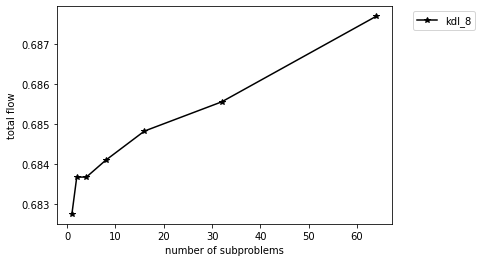

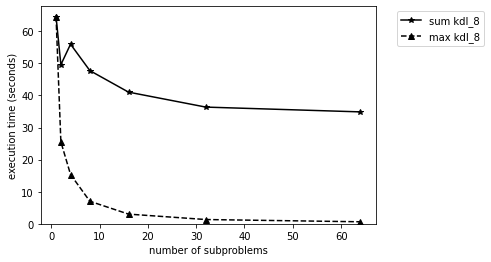

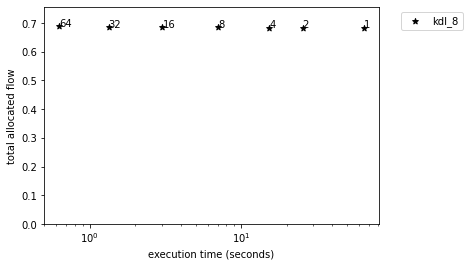

In [16]:
#problems = [p6]
#plot_benchmark(results_all_obj, runtimes_all_obj, sol_dicts_all_obj, 
#               results_ncflow, runtimes_ncflow)
results_ncflow = None
runtimes_ncflow = None
plot_benchmark(results_all_obj_smart, runtimes_all_obj_smart, 
               sol_dicts_all_obj_smart, results_ncflow, runtimes_ncflow)


In [11]:
num_paths, edge_disjoint, dist_metric = PATH_FORM_HYPERPARAMS
problem = Problem.from_file("../topologies/topology-zoo/GtsCe.graphml", 
                            "../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl")
problem.G
#print(problem.G.edges.data())
com_list = problem.commodity_list
#problem2 = problem.copy()
#print(dir(problem))

pf = PathFormulation.new_max_flow(
                    num_paths,
                    edge_disjoint=edge_disjoint,
                    dist_metric=dist_metric)
        
paths_dict = pf.get_paths(problem)

com0 = com_list[3]
print(com0)
print(paths_dict[(com0[1][0],com0[1][1])])

"""
problem2.traffic_matrix.tm
new_tm = problem2.traffic_matrix.tm[0:10,:]

num_rows = len(problem2.traffic_matrix.tm)

shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)

num_first_problem = math.floor(num_rows/2)

for i in shuffled_indices[1:num_first_problem]:
    problem2.traffic_matrix.tm[i,:] = 0

#print(problem2.traffic_matrix.tm[1:5,:])

for u,v in problem.G.edges:
    problem.G[u][v]['capacity'] = problem.G[u][v]['capacity']/2
    problem2.G[u][v]['capacity'] = problem2.G[u][v]['capacity']/2
"""

Loading paths from pickle file /lfs/1/fiodar/ncflow/topologies/paths/path-form/GtsCe.graphml-4-paths_edge-disjoint-True_dist-metric-inv-cap-dict.pkl
paths_dict size: 22052
(3, (0, 4, 2.2596655))
[[0, 14, 94, 93, 96, 95, 16, 4]]


"\nproblem2.traffic_matrix.tm\nnew_tm = problem2.traffic_matrix.tm[0:10,:]\n\nnum_rows = len(problem2.traffic_matrix.tm)\n\nshuffled_indices = list(range(num_rows))\nrandom.shuffle(shuffled_indices)\n\nnum_first_problem = math.floor(num_rows/2)\n\nfor i in shuffled_indices[1:num_first_problem]:\n    problem2.traffic_matrix.tm[i,:] = 0\n\n#print(problem2.traffic_matrix.tm[1:5,:])\n\nfor u,v in problem.G.edges:\n    problem.G[u][v]['capacity'] = problem.G[u][v]['capacity']/2\n    problem2.G[u][v]['capacity'] = problem2.G[u][v]['capacity']/2\n"

In [37]:
def CSPF(problems):

    for problem_name, topo_fname, tm_fname in problems:
        problem = Problem.from_file(topo_fname, tm_fname)
        
        com_list = problem.commodity_list
        tm = problem.traffic_matrix.tm
        
        pf = PathFormulation.new_max_flow(
                    num_paths,
                    edge_disjoint=edge_disjoint,
                    dist_metric=dist_metric)
        
        paths_dict = pf.get_paths(problem)
        
        # initialize link capacity dict
        remaining_link_capacity_dict = {}
        for u,v in problem.G.edges:
            remaining_link_capacity_dict[(u,v)] = problem.G[u][v]['capacity']
            
        # sort paths in ascending order
        all_paths_list = []
        for k, (source, target, demand) in com_list:
            paths_array = paths_dict[(source, target)]
            all_paths_list += paths_array
            
        all_paths_list.sort(key=len)
        
        # iterate through sorted paths
        allocated_coms = []
        total_allocated_flow = 0
        startTime = datetime.now()
        for path in all_paths_list:
            source = path[0]
            target = path[-1]
            demand = tm[source,target]
            
            # skip if we have already allocated this commodity
            if (source, target) in allocated_coms:
                continue
            
            # check that each edge in list has enough capacity
            edge_list = list(path_to_edge_list(path))
            room = True
            for u,v in edge_list:
                if remaining_link_capacity_dict[(u,v)] < demand:
                    room = False
            
            if not room:
                continue
            
            # allocate
            for u,v in edge_list:
                remaining_link_capacity_dict[(u,v)] -= demand
            allocated_coms.append((source, target))
            total_allocated_flow += demand
        runtime = datetime.now() - startTime
        print("Runtime: " + str(runtime))
        print("Allocated Flow:" + str(total_allocated_flow))

In [38]:
CSPF(problems)

Loading paths from pickle file /lfs/1/fiodar/ncflow/topologies/paths/path-form/Kdl.graphml-4-paths_edge-disjoint-True_dist-metric-inv-cap-dict.pkl
paths_dict size: 567762
Runtime: 1:52:47.242754
Allocated Flow:63296.23755243822


In [36]:
print(datetime.now())

2021-01-31 19:02:49.272325
